# Multi $\kappa$ Scale Factor
This applies the scale factor theory to all simulations, through regression.

In [1]:
import copy
import sys
import os

# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, R
from isca_tools.convection.base import lapse_moist, lapse_dry
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_theory_prefactor_terms, get_p_x, get_temp_adiabat_surf, get_temp_adiabat
from isca_tools.thesis.adiabat_theory2 import get_approx_terms, get_scale_factor_theory, get_sensitivity_factors, \
    decompose_var_x_change, get_cape_approx, get_scale_factor_theory_numerical
from isca_tools.utils.stats import z_score_from_confidence_interval
from isca_tools.plot import label_subplots, fig_resize, update_linewidth, update_fontsize
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
import warnings
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
fig_data_dir = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/land/meridional_band/publish_figures/paper_fig_data/'
load_data = True
is_land_data = False         # Whether to load in land or aquaplanet data, only used in load_data is False
use_land_evap = False        # if True, will load in constant evap version of land; otherwise will load normal bucket_evap data


plot_info = {'aquaplanet': {}, 'land': {}}
if load_data:
    data_load = np.load(os.path.join(fig_data_dir, 'aquaplanet.npz'), allow_pickle=True)
    plot_info['aquaplanet'] = {key: dict(data_load[key]) for key in data_load.files}['data']
    data_load = np.load(os.path.join(fig_data_dir, 'land_evap.npz' if use_land_evap else 'land.npz'), allow_pickle=True)
    plot_info['land'] = {key: dict(data_load[key]) for key in data_load.files}['data']
    print('Data in plot_info loaded from:\n{}'.format(fig_data_dir))
else:
    if is_land_data:
        if use_land_evap:
            exp_dir = 'tau_sweep/land/meridional_band/depth=1/evap/'              # Land constant evaporative prefactor - only for two figures
        else:
            exp_dir = 'tau_sweep/land/meridional_band/depth=1/bucket_evap/'       # Land
    else:
        exp_dir = 'tau_sweep/aquaplanet/depth=1/'                                 # Aquaplanet
    print('Data not loaded in, will generate for:\n{}'.format(exp_dir))

Data in plot_info loaded from:
/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/land/meridional_band/publish_figures/paper_fig_data/


In [3]:
# If true, will save ALL figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5, 'two_thirds': 4.5}        # width in inches
save_pad_inches = 0.05

leg_info = {'handlelength': 1, 'labelspacing': 0.2, 'columnspacing': 0.9, 'handletextpad': 0.5}       # info for legend
def add_legend(ax, handles=None, labels=None, ncol=1, title=None, loc=None, frameon=False, edgecolor="k", borderpad=None,
               labelspacing=leg_info['labelspacing'], handlelength=leg_info['handlelength'],
               columnspacing=leg_info['columnspacing'], handletextpad=leg_info['handletextpad'],
               bbox_to_anchor=None):
    if handles is None:
        return ax.legend(ncol=ncol, title=title, loc=loc, frameon=frameon, edgecolor=edgecolor, borderpad=None,
                 labelspacing=labelspacing, handlelength=handlelength,
                 columnspacing=columnspacing, handletextpad=handletextpad, bbox_to_anchor=bbox_to_anchor)
    else:
        return ax.legend(handles, labels, ncol=ncol, title=title, loc=loc, frameon=frameon, edgecolor=edgecolor, borderpad=None,
                         labelspacing=labelspacing, handlelength=handlelength,
                         columnspacing=columnspacing, handletextpad=handletextpad, bbox_to_anchor=bbox_to_anchor)


# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']
#
# labels_exp = ['$\kappa={:.1f}$'.format(tau_lw[i]) for i in range(n_kappa)]

In [4]:
if not load_data:
    # Load dataset - one at surface and one in free troposphere
    var_keep = ['temp', 'sphum', 'height', 'cape', 'klzbs']        # only keep variables required to compute relative humidity and MSE
    use_time_start = 360*2
    pressure_ft = 500               # Desired approximate pressure of free troposphere (hPa)

    kappa_names = [dir for dir in os.listdir(os.path.join(os.environ['GFDL_DATA'],exp_dir)) if (dir[0]=='k' and '_2m' not in dir)]
    kappa_names.sort()
    n_kappa = len(kappa_names)

    ds = []
    albedo = []
    tau_sw = []
    tau_lw = []
    with tqdm(total=n_kappa, position=0, leave=True) as pbar:
        for j in range(n_kappa):
            ds_use = isca_tools.load_dataset(exp_dir + kappa_names[j]).sel(time=slice(use_time_start, np.inf))[var_keep]

            ds += [ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')]      # only keep the surface and free troposphere values
            namelist = isca_tools.load_namelist(exp_dir + kappa_names[j])  # Need this for albedo_value
            albedo += [namelist['mixed_layer_nml']['albedo_value']]
            tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
            tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
            pbar.update(1)
    tau_lw = np.asarray(tau_lw)
    pfull = ds_use.pfull
    ind_surf = 0
    ind_ft = 1
    p_surface = float(ds[0].pfull[ind_surf]) * 100
    pressure_ft_actual = float(ds[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)
    n_pressure = ds[0].pfull.size
    # sigma_half reflects ds_us.pfull (starts with 0 - space, ends with 1 - surface)
    sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
    sigma_levels_full = np.convolve(sigma_levels_half, np.ones(2)/2, 'valid')       # sigma levels corresponding to pressure levels
else:
    tau_lw = plot_info['land']['tau_lw']
    n_kappa = len(tau_lw)
    ind_surf = np.argmax(plot_info['land']['pressure'])
    ind_ft = np.argmin(plot_info['land']['pressure'])
    p_surface = plot_info['land']['pressure'][ind_surf]
    pressure_ft_actual = plot_info['land']['pressure'][ind_ft]
    n_pressure = len(plot_info['land']['pressure'])     # should be 2
    namelist = isca_tools.load_namelist(plot_info['land']['exp_dir'] + 'k=1')
    sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
    sigma_levels_full = np.convolve(sigma_levels_half, np.ones(2)/2, 'valid')       # sigma levels corresponding to pressure levels
R_mod = get_theory_prefactor_terms(0, p_surface, pressure_ft_actual)[0]   # need to compute mse_mod

## Get datasets
Get one dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the all or just tbe summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [5]:
# Show where the land is
if not load_data:
    save_land_fig = False

    job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
    land_file_name = os.path.join(job_dir, exp_dir, kappa_names[0], 'land.nc')
    if is_land_data != os.path.exists(land_file_name):
        raise ValueError('Land data not found at {}'.format(land_file_name))
    if is_land_data:
        fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
        isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
        lon_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]       # get the longitude coordinates of land

        if save_land_fig:
            isca_tools.savefig(fig, 'land_coords', dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches,
                           save_if_exists=False)






### Get Average of Variables
Get average values of various quantities required for scaling factor theory.

In [6]:
if load_data:
    lat = plot_info['land']['lat']
    n_lat = len(lat)
    lat_weights = np.cos(np.deg2rad(lat))
else:
    # Load in across all latitudes, for given season
    # Select region to combine latitudes over for all but one of the plots below
    # Tropics
    region = 'tropics'
    lat_min = 0
    lat_max = 20
    # Extratropics
    # region = 'extratropics'
    # lat_min = 40
    # lat_max = 65
    # lat_min = 70
    # lat_max = 90

    # Chose whether to only consider summer days or consider all days
    # season = 'all'
    season = 'summer'
    # season = 'winter'
    if season == 'summer':
        if region == 'tropics':
            season_months = {'nh': [5, 6, 7, 8, 9, 10], 'sh': [11, 12, 1, 2, 3, 4]}
        else:
            season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
    elif season == 'winter':
        if region == 'tropics':
            season_months = {'sh': [5, 6, 7, 8, 9, 10], 'nh': [11, 12, 1, 2, 3, 4]}
        else:
            season_months = {'sh': [6, 7, 8], 'nh': [12, 1, 2]}

    lat_use_ind = np.where((np.abs(ds[0].lat) <= lat_max) & (np.abs(ds[0].lat) >= lat_min))[0]
    n_lat = len(lat_use_ind)
    lat_weights = np.cos(np.deg2rad(ds[0].lat))[lat_use_ind]
    lat = ds[0].lat[lat_use_ind].to_numpy()

    # Whether to do taylor expansion about mean over just land or mean over whole planet
    mean_method = 'land'
    # mean_method = 'all'

    temp_av = {key: np.zeros((n_kappa, n_pressure, n_lat)) for key in ['mean', 'median']}
    z_av = {key: np.zeros((n_kappa, n_pressure, n_lat)) for key in ['mean', 'median']}
    r_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}
    epsilon_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}
    z_approx_error_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}        # error in z used in mse_mod approx
    cape_sim_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}
    # Decide how to compute humidities - do q first and then r from this ('sphum'), or vice versa ('r')?

    ds_all = []
    with tqdm(total=n_kappa, position=0, leave=True) as pbar:
        for j in range(n_kappa):
            ds_use = ds[j].isel(lat=lat_use_ind)   # only keep latitudes being used to save memory

            if is_land_data:
                # if not aquaplanet, then is land and only consider land longitudes
                ds_use = ds_use.isel(lon=np.where(np.isin(ds_use.lon, np.unique(lon_land)))[0])

            if season in ['summer', 'winter']:
                ds_nh_season = isca_tools.utils.annual_time_slice(ds_use, season_months['nh']).sel(lat=slice(0, 90))
                ds_sh_season = isca_tools.utils.annual_time_slice(ds_use, season_months['sh']).sel(lat=slice(-90, 0))
                # Combine hemispheres and average over longitude, time and latitude.
                ds_use = xr.concat([ds_sh_season, ds_nh_season], dim='lat')
            ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
            ds_all += [ds_use.load()]

            if mean_method == 'all':
                ds_use = ds[j].sel(time=slice(use_time_start, np.inf)).isel(lat=lat_use_ind)
                ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
            elif mean_method != 'land':
                raise ValueError(f'Mean method is {mean_method} which is not valid.')
            temp_av['mean'][j] = ds_use.temp.mean(dim='lon_time')
            temp_av['median'][j] = ds_use.temp.median(dim='lon_time')
            z_av['mean'][j] = ds_use.height.mean(dim='lon_time')
            z_av['median'][j] = ds_use.height.mean(dim='lon_time')
            rh_use = ds_use.sphum.isel(pfull=ind_surf)/sphum_sat(ds_use.temp.isel(pfull=ind_surf), p_surface)
            r_av['mean'][j] = rh_use.mean(dim='lon_time')
            r_av['median'][j] = rh_use.median(dim='lon_time')
            mse_use_surf = moist_static_energy(ds_use.temp.isel(pfull=ind_surf), ds_use.sphum.isel(pfull=ind_surf), height=ds_use.height.isel(pfull=ind_surf))
            mse_use_ft = moist_static_energy(ds_use.temp.isel(pfull=ind_ft), sphum_sat(ds_use.temp.isel(pfull=ind_ft), pressure_ft_actual),
                                             height=ds_use.height.isel(pfull=ind_ft))
            epsilon_use = mse_use_surf-mse_use_ft
            epsilon_av['mean'][j] = epsilon_use.mean(dim='lon_time')
            epsilon_av['median'][j] = epsilon_use.median(dim='lon_time')
            mse_mod_use = moist_static_energy(ds_use.temp.isel(pfull=ind_surf), ds_use.sphum.isel(pfull=ind_surf), height=0, c_p_const=c_p-R_mod
                                              ) - epsilon_use
            mse_mod_use_ft_approx = moist_static_energy(ds_use.temp.isel(pfull=ind_ft), sphum_sat(ds_use.temp.isel(pfull=ind_ft), pressure_ft_actual),
                                                        height=0, c_p_const=c_p+R_mod)
            z_error_use = mse_mod_use - mse_mod_use_ft_approx
            z_approx_error_av['mean'][j] = z_error_use.mean(dim='lon_time')
            z_approx_error_av['median'][j] = z_error_use.median(dim='lon_time')
            cape_sim_av['mean'][j] = ds_use.cape.mean(dim='lon_time')/1000          # put in units of kJ/kg
            cape_sim_av['median'][j] = ds_use.cape.median(dim='lon_time')/1000      # put in units of kJ/kg
            pbar.update(1)

### Get quantile variables
Get variables required for scaling factor theory conditioned on near-surface percentile, $x$, in `_quant3` arrays. Also, get actual distribution of some variables in `_quant` arrays.

In [7]:
def get_cape_approx_quant(temp_surf, rh, temp_ft, epsilon, quant, pressure_surf=p_surface, pressure_ft=pressure_ft_actual, batch_size=1000):
    # Computes approx cape from 1D arrays of temp_surf, rh, temp_ft, epsilon
    # Then computes quantiles of resultant cape array
    # Expect large array hence, give batch size to make more efficient
    use_ind = np.where(~np.isnan(temp_surf))[0]         # only consider non-nan elements
    cape_all = np.zeros(use_ind.size)
    ind_batches = np.array_split(np.arange(use_ind.size), np.ceil(use_ind.size / batch_size))
    for ind in ind_batches:
        cape_all[ind] = get_cape_approx(temp_surf[use_ind[ind]], rh[use_ind[ind]], pressure_surf, pressure_ft,
                                        temp_ft[use_ind[ind]], epsilon[use_ind[ind]])[0]
    return np.quantile(cape_all, quant)     # units are kJ/kg

In [8]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
if load_data:
    quant_plot = plot_info['land']['quant_plot']
    quant_px = plot_info['land']['quant_px']
    n_quant = len(quant_plot)
if not load_data:
    quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
    quant_px = np.arange(101)      # go from 0 to 100 inclusive for p_x calculation to ensure dont get negative p_x in interpolation
    n_quant = len(quant_plot)
    # quant3 is conditioned on near-surface temperature
    temp_quant3 = np.zeros((n_kappa, n_pressure, n_lat, n_quant))
    sphum_quant3 = np.zeros((n_kappa, n_lat, n_quant))
    z_quant3 = np.zeros((n_kappa, n_pressure, n_lat, n_quant))
    convflag_quant3 = np.zeros((n_kappa, n_lat, n_quant))
    cape_sim_quant3 = np.zeros((n_kappa, n_lat, n_quant))
    klzbs_quant3 = np.zeros((n_kappa, n_lat, n_quant))

     # quantile is actual quantile
    temp_ft_quant = np.zeros((n_kappa, n_lat, quant_px.size))
    r_quant = np.zeros((n_kappa, n_lat, quant_px.size))
    epsilon_quant = np.zeros((n_kappa, n_lat, quant_px.size))
    cape_quant = np.zeros((n_kappa, n_lat, quant_px.size))

    quick_cape_calc = True  # cape_quant calc takes a long time, so give option to take zonal average for each time before computation to quicken
    skip_cape_calc = True   # cape calc long so can skip here
    if quick_cape_calc:
        f_cape = lambda x: x.groupby(x.time).mean(dim='lon_time')       # Take zonal average at each time step
    else:
        f_cape = lambda x: x        # do nothing
    # For actual paper, this should be false though

    with tqdm(total=n_kappa*n_lat, position=0, leave=True) as pbar:
        for j in range(n_kappa):
            ds_use = ds_all[j]
            rh_use = ds_use.sphum.isel(pfull=ind_surf)/sphum_sat(ds_use.temp.isel(pfull=ind_surf), p_surface)
            mse_use = [moist_static_energy(ds_use.temp[ind_surf], ds_use.sphum[ind_surf], ds_use.height[ind_surf]),
                       moist_static_energy(ds_use.temp[ind_ft], sphum_sat(ds_use.temp[ind_ft], pressure_ft_actual), ds_use.height[ind_ft])]
            mse_mod_use = moist_static_energy(ds_use.temp[ind_ft], sphum_sat(ds_use.temp[ind_ft], pressure_ft_actual), height=0, c_p_const=c_p + R_mod)
            epsilon_use = mse_use[0] - mse_use[1]
            temp_ft_quant[j] = ds_use.temp.isel(pfull=ind_ft).quantile(quant_px / 100, dim='lon_time').transpose()
            r_quant[j] = rh_use.quantile(quant_px / 100, dim='lon_time').transpose()
            epsilon_quant[j] = epsilon_use.quantile(quant_px / 100, dim='lon_time').transpose()
            for k in range(n_lat):
                if not skip_cape_calc:
                    # cape_quant takes about 20 seconds per latitude for land, couple minutes for aquaplanet so save first time it is produced
                    cape_quant[j, k] = get_cape_approx_quant(f_cape(ds_use.temp.isel(pfull=ind_surf, lat=k)).to_numpy(),
                                                             f_cape(rh_use.isel(lat=k)).to_numpy(),
                                                             f_cape(ds_use.temp.isel(pfull=ind_ft, lat=k)).to_numpy(),
                                                             f_cape(epsilon_use.isel(lat=k)).to_numpy(), quant_px / 100)
                for q, quant in enumerate(quant_plot):
                    use_ind = get_quant_ind(ds_use.temp[ind_surf, k], quant, 0.5, 0.5)
                    # Make sure to compute temp_quant at FT level using near-surface quantiles
                    temp_quant3[j, :, k, q] = ds_use.temp[:, k, use_ind].mean(dim='lon_time')
                    z_quant3[j, :, k, q] = ds_use.height[:, k, use_ind].mean(dim='lon_time')
                    sphum_quant3[j, k, q] = ds_use.sphum[ind_surf, k, use_ind].mean(dim='lon_time')
                    cape_sim_quant3[j, k, q] = ds_use.cape[k, use_ind].mean(dim='lon_time')/1000        # units of kJ/kg
                    klzbs_quant3[j, k, q] = ds_use.klzbs[k, use_ind].mean(dim='lon_time')
                pbar.update(1)

    # computed as in get_scaling_factor_theory function in adiabat_theory.py, computing sphum quant first
    # Really doesn't matter though but I think this method is simpler
    # When computing average, I think it does make more sense to compute sphum_av from r_av because theory built around RH
    r_quant3 = sphum_quant3 / sphum_sat(temp_quant3[:, ind_surf], p_surface)
percentile_label = 'Temperature percentile, $x$'

In [9]:
if not load_data:
    # Copy epsilon calculation from get_scaling_factor_theory function in adiabat_theory.py
    # In units of kJ/kg
    epsilon_quant3 = (moist_static_energy(temp_quant3[:, ind_surf], sphum_quant3, height=z_quant3[:, ind_surf]) -
                     moist_static_energy(temp_quant3[:, ind_ft], sphum_sat(temp_quant3[:, ind_ft], pressure_ft_actual), z_quant3[:, ind_ft]))
    cape_quant3 = np.zeros((n_kappa, n_lat, n_quant))
    for i in range(n_kappa):
        for j in range(n_lat):
            cape_quant3[i, j] = get_cape_approx(temp_quant3[i, ind_surf, j], r_quant3[i, j], p_surface, pressure_ft_actual,
                                                   temp_quant3[i, ind_ft, j], epsilon_quant3[i, j])[0]

## Reference Climate
In the theory, we are free to choose the reference day, and the change with warming of this day, that the theory is built around. We must specify the reference surface temperature, $\tilde{T}_s$, relative humidity, $\tilde{r}_s$, CAPE proxy, $\tilde{\epsilon}$ and error due to approximation of geopotential height, $\tilde{A}_z$.

Given these three values, we can compute the reference free tropospheric temperature, $\tilde{T}_{FT}$, by equating two equations for reference modified MSE, $\tilde{h}^{\dagger}$:

$\tilde{h}^{\dagger} = (c_p - R^{\dagger})\tilde{T}_s + L_v \tilde{q}_s - \epsilon = (c_p + R^{\dagger})\tilde{T}_{FT} + L_vq^*(\tilde{T}_{FT}, p_{FT})
 + \tilde{A}_z$

Where we use the computed average error due to z approximation, $\tilde{A}_z$ in this computation of $\tilde{T}_{FT}$.

For ease of interpretation later, I propose:
* $\tilde{T}_s = \overline{T_s}; \delta \tilde{T}_s = \delta \overline{T_s}$
* $\tilde{r}_s = \overline{r_s}; \delta \tilde{r}_s = 0$
* $\tilde{\epsilon} = 0; \delta \tilde{\epsilon} = 0$
* $\tilde{A}_z = \overline{A}_z; \delta \tilde{A}_z = 0$

where the overline refers to the time-zonal mean value of that quantity.

In [10]:
if not load_data:
    av_use = 'mean'
    # Recommended reference day
    # SUBTLE POINT FOR REF RH WHEN USING MULTIPLE SIMULATIONS
    # for each neighbouring simulation, assume r_ref constant with warming hence add duplicate 3rd axis
    # shape is n_exp x n_lat x 2 so to get scale factor for experiment i to i+1 latitude j, give r_ref[i, j, :]
    r_ref = np.tile(r_av[av_use][:, :, np.newaxis], [1, 1, 2])
    epsilon_ref = np.zeros((n_kappa, n_lat))        # Normalise relative to day with zero CAPE in each simulation         # use actual average epsilon
    temp_surf_ref = temp_av[av_use][:, ind_surf] # Have actual average surface temperature change with warming
    z_approx_error_ref = np.zeros((n_kappa, n_lat))
    cape_sim_ref = np.zeros((n_kappa, n_lat))
    cape_ref = np.zeros((n_kappa, n_lat))

    # Amendment if want to use actual average day as reference in both climates
    use_av_as_ref = False
    if use_av_as_ref:
        r_ref[:-1, :, 1] = r_av[av_use][1:]        # account for actual change in reference between subsequent experiments
        epsilon_ref[:] = epsilon_av[av_use]
        z_approx_error_ref[:] = z_approx_error_av[av_use]
        cape_sim_ref = cape_sim_av[av_use]
        for i in range(n_kappa):
            for j in range(n_lat):
                cape_ref[i, j] = get_cape_approx(temp_surf_ref[i, j], r_ref[i, j], p_surface, pressure_ft_actual,
                                                 epsilon=epsilon_ref[i, j], z_approx=z_approx_error_ref[i, j])[0]

### Figure - Changing $T_s$ with warming
Show the $T_s$ distribution for each simulation, to indicate land distribution widens, but aquaplanet does the opposite.

In [11]:
if not load_data:
    # Add 1st data to plot_info required for plotting
    zero_plot_info_arrays = {'exp_dir': '', 'tau_lw': np.asarray([]), 'av_use': '', 'quant_plot': np.asarray([]),
                             'quant_px': np.asarray([]),
                             'pressure': np.zeros(n_pressure), 'lat': np.zeros(n_lat),
                             'temp_s_anom': np.zeros_like(temp_quant3[:, ind_surf]),
                             'temp_s_av': np.zeros((n_kappa, n_lat)), 'r_av': np.zeros((n_kappa, n_lat)),
                             'cape_quant': np.zeros((n_kappa, n_lat, n_quant)), 'cape_quant3': np.zeros((n_kappa, n_lat, n_quant)),
                             'temp_ft_quant': np.zeros((n_kappa, n_lat, n_quant)),
                             'temp_quant3': np.zeros((n_kappa, n_pressure, n_lat, n_quant)),
                             'r_quant': np.zeros((n_kappa, n_lat, n_quant)),
                             'r_quant3': np.zeros((n_kappa, n_lat, n_quant)),
                             'r_ref': np.zeros((n_kappa, n_lat)),
                             'epsilon_ref': np.zeros((n_kappa, n_lat)),
                             'temp_surf_ref': np.zeros((n_kappa, n_lat)),
                             'z_approx_error_ref': np.zeros((n_kappa, n_lat)),
                             'klzbs_quant3': np.zeros((n_kappa, n_lat, n_quant)),
                             }
    # First initialise arrays as zero, if don't exist already
    for key in ['aquaplanet', 'land']:
        for key2 in zero_plot_info_arrays:
            try:
                plot_info[key][key2]       # just to key exists
            except KeyError:
                # If variable doesn't exist, create it with all values set to 0
                plot_info[key][key2] = copy.deepcopy(zero_plot_info_arrays[key2])

    # Add data for current dataset
    plot_info['land' if is_land_data else 'aquaplanet']['exp_dir'] = exp_dir      # record experiment used
    plot_info['land' if is_land_data else 'aquaplanet']['tau_lw'] = tau_lw        # record kappa values used
    plot_info['land' if is_land_data else 'aquaplanet']['av_use'] = av_use        # averaging method used
    plot_info['land' if is_land_data else 'aquaplanet']['quant_plot'] = quant_plot   # averaging method used
    plot_info['land' if is_land_data else 'aquaplanet']['quant_px'] = quant_px   # averaging method used
    plot_info['land' if is_land_data else 'aquaplanet']['pressure'][[ind_surf, ind_ft]] = [p_surface, pressure_ft_actual]       # record pressure values
    plot_info['land' if is_land_data else 'aquaplanet']['lat'] = lat
    plot_info['land' if is_land_data else 'aquaplanet']['temp_s_anom'] = temp_quant3[:, ind_surf] - temp_av[av_use][:, ind_surf, :, np.newaxis]
    plot_info['land' if is_land_data else 'aquaplanet']['temp_s_av'] = temp_av[av_use][:, ind_surf]
    plot_info['land' if is_land_data else 'aquaplanet']['r_av'] = r_av[av_use]
    # Save all quantile and ref data for future reference
    plot_info['land' if is_land_data else 'aquaplanet']['cape_quant'] = cape_quant          # save cape_quant as takes a long time to make
    plot_info['land' if is_land_data else 'aquaplanet']['cape_quant3'] = cape_quant3        # save cape_quant3 to emphasize cape_quant is different
    plot_info['land' if is_land_data else 'aquaplanet']['temp_ft_quant'] = temp_ft_quant
    plot_info['land' if is_land_data else 'aquaplanet']['temp_quant3'] = temp_quant3
    plot_info['land' if is_land_data else 'aquaplanet']['r_quant'] = r_quant
    plot_info['land' if is_land_data else 'aquaplanet']['r_quant3'] = r_quant3
    plot_info['land' if is_land_data else 'aquaplanet']['r_ref'] = r_ref
    plot_info['land' if is_land_data else 'aquaplanet']['epsilon_ref'] = epsilon_ref
    plot_info['land' if is_land_data else 'aquaplanet']['temp_surf_ref'] = temp_surf_ref
    plot_info['land' if is_land_data else 'aquaplanet']['z_approx_error_ref'] = z_approx_error_ref
    plot_info['land' if is_land_data else 'aquaplanet']['klzbs_quant3'] = klzbs_quant3

In [12]:
# Print mean temperature change for kappa<1.5 and kappa>1.5
ind_kappa1_5 = np.where(tau_lw==1.5)[0][0]
for key in plot_info:
    var = np.average(plot_info[key]['temp_s_av'], axis=1, weights=lat_weights)
    print("{}: {:.1f}".format(key+ ' (cold)', var[ind_kappa1_5] - var[0]))
    print("{}: {:.1f}".format(key+ ' (hot)', var[-1] - var[ind_kappa1_5]))

aquaplanet (cold): 10.1
aquaplanet (hot): 8.9
land (cold): 14.6
land (hot): 12.1


In [13]:
# Print change in actual distribution between two quantiles for kappa=1 simulation
# Idea is to show variation much larger for land so smaller percentile change required for same scaling factor contribution
tau_use = 1
quant_use = [25, 75]        # use 25, 75 as IQR
ind_use = [np.where(tau_lw==tau_use)[0][0], np.where(quant_px==quant_use[0])[0][0], np.where(quant_px==quant_use[1])[0][0]]
for key in plot_info:
    for key2 in ['temp_ft', 'r', 'cape']:
        var = plot_info[key][key2+'_quant'][ind_use[0], :, ind_use[2]] - plot_info[key][key2+'_quant'][ind_use[0], :, ind_use[1]]
        var = np.average(var, axis=0, weights=lat_weights)
        if key2 == 'r':
            var *= 100   # convert to %
        if key2 == 'cape':
            var *= 1000  # convert to J/kg
        print(key, key2, '{:.2f}'.format(var))

aquaplanet temp_ft 3.61
aquaplanet r 3.34
aquaplanet cape 0.00
land temp_ft 3.90
land r 16.83
land cape 0.00


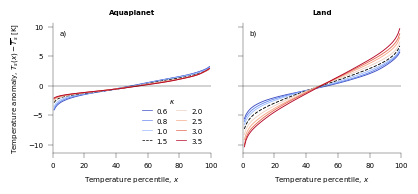

In [14]:
colors_kappa = plt.cm.coolwarm(np.linspace(0, 1, n_kappa))
colors_kappa = np.concatenate([colors_kappa[:ind_kappa1_5], np.asarray([0, 0, 0, 1])[np.newaxis], colors_kappa[4:]])

save_temp_anom_fig = False
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
fig_resize(fig, width['two_thirds'], ar=ar)
# fig, ax = plt.subplots(1,2, figsize=get_figsize(2, 1, width['two_thirds']), sharex=True, sharey=True)
for j, key in enumerate(plot_info):
    ax[j].set_title(key.capitalize(), fontweight='bold')
    ax[j].set_xlabel('Temperature percentile, $x$')
    for i in range(n_kappa):
        ax[j].plot(quant_plot, np.average(plot_info[key]['temp_s_anom'][i], axis=0, weights=lat_weights),
               color=colors_kappa[i], label='{:.1f}'.format(tau_lw[i]), linestyle='--' if i==3 else None)
add_legend(ax[0], ncol=2, title='$\kappa$', loc='lower right')
ax[0].set_ylabel('Temperature anomaly, $T_s(x)-\overline{T}_s$ [K]')
ax[0].set_xlim(0, 100)
label_subplots(fig, ax)
update_fontsize(fig)
update_linewidth(fig)

# always add hline at the end so does not scale
for ax_use in ax:
    ax_use.axhline(0, color='k', lw=ax_linewidth)
if use_land_evap:
    plt.close()         # if fixed evap dataset, don't need this figure
else:
    plt.show()
    if save_temp_anom_fig or save_fig:
        isca_tools.savefig(fig, 'temp_surf_anom', dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches,
                           save_if_exists=False)

In [15]:
# Quantify narrowing / broadening of the distribution through standard deviation
for key in plot_info:
    var = np.round(np.average(np.std(plot_info[key]['temp_s_anom'], axis=2), axis=1, weights=lat_weights), 2)
    print(key, 'stdev:', var)
    var = np.average(np.std(plot_info[key]['temp_s_anom'][:, :, quant_plot<=50], axis=2), axis=1, weights=lat_weights)
    print(key, 'stdev change (x<=50):', np.round(var[0]-var[-1], 2))
    var = np.average(np.std(plot_info[key]['temp_s_anom'][:, :, quant_plot>=50], axis=2), axis=1, weights=lat_weights)
    print(key, 'stdev change (x>=50):', np.round(var[0]-var[-1], 2))

aquaplanet stdev: [1.66 1.6  1.5  1.35 1.26 1.23 1.21 1.2 ]
aquaplanet stdev change (x<=50): 0.5
aquaplanet stdev change (x>=50): 0.03
land stdev: [2.38 2.59 2.8  3.15 3.57 4.   4.33 4.65]
land stdev change (x<=50): -1.37
land stdev change (x>=50): -0.91


### Figure - Sensitivity Parameters
#### Inverted
Plot the sensitivity parameters for each of the 6 mechanisms in the scaling factor theory.
Plot these as the value of each variable required to give a $0.1$ contribution to the scaling factor i.e. smaller values mean more sensitive.

In [16]:
n_temp_gamma_plot = 81
n_rh_gamma_plot = 101
temp_gamma_plot = np.linspace(285, 333, n_temp_gamma_plot)
rh_gamma_plot = np.linspace(0.2, 0.8, n_rh_gamma_plot)
gamma = {key: np.zeros((n_temp_gamma_plot, n_rh_gamma_plot)) for key in
         ['temp_ft_change', 'r_change', 'cape_change', 'temp_anom', 'r_anom']}

for i in range(n_temp_gamma_plot):
    for j in range(n_rh_gamma_plot):
        var = get_sensitivity_factors(temp_gamma_plot[i], rh_gamma_plot[j], p_surface, pressure_ft_actual, cape_form=True)
        for key in gamma:
            gamma[key][i, j] = var[key]

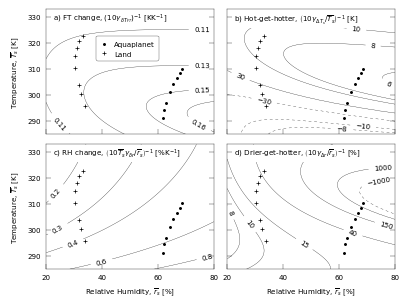

In [17]:
gamma_prefactor = {'temp_ft_change': 1, 'r_change': temp_gamma_plot[:, np.newaxis]/rh_gamma_plot[np.newaxis]/100,
                   'cape_change': 1/R_mod,
                   'temp_anom': 1/temp_gamma_plot[:, np.newaxis], 'r_anom': 1/rh_gamma_plot[np.newaxis]/100}
gamma_plot_levels = {'temp_ft_change': np.asarray([0.11, 0.13, 0.15, 0.16]),
                     'r_change': np.asarray([0.2, 0.3, 0.4, 0.6, 0.8]),
                     'cape_change': np.asarray([11, 13, 15, 16]),
                     'temp_anom': {'pos': np.asarray([6, 8, 10, 30]),
                                   'neg': np.asarray([-30, -10, -8, -6])},
                     'r_anom': {'pos': np.asarray([8, 10, 15, 40, 150, 1000]),
                                'neg': np.asarray([-1000])}}
gamma_plot_labels = {'temp_ft_change': '$\\left(10\gamma_{\delta T_{FT}}\\right)^{-1}$ [KK$^{-1}$]',
                     'r_change': '$\\left(10\overline{T}_s\gamma_{\delta r}/\overline{r}_s\\right)^{-1}$ [%K$^{-1}$]',
                     'cape_change': '$\\left(10\gamma_{\delta T_{FT}}/R^{\dagger}\\right)^{-1}$ [Jkg$^{-1}$K$^{-1}$]',
                     'temp_anom': '$\\left(10\gamma_{\Delta T_s}/\overline{T}_s\\right)^{-1}$ [K]',
                     'r_anom': '$\\left(10\gamma_{\Delta r}/\overline{r}_s\\right)^{-1}$ [%]'}
labels_cont = {'temp_ft_change': 'FT change', 'r_change': 'RH change', 'cape_change': 'CAPE change',
               'temp_anom': 'Hot-get-hotter', 'r_anom': 'Drier-get-hotter'}
lw_contour = 0.2
fontsize_contour = 5
marker_sz_publish = 5

show_cape_subplot = False       # cape sensitivity is same as temp_ft, so think it makes sense to not show it
save_gamma_invert_fig = False
# fig, ax = plt.subplots(3,2, figsize=(im_sz*width['two_col'], im_sz*3*width['two_col']/2/ar), sharex=True, sharey=True)
fig, ax = plt.subplots(2+int(show_cape_subplot),2, sharex=True, sharey=True)
fig_resize(fig, width['two_thirds'])
ax = ax.transpose().flatten()
keys_plot = [key for key in gamma_plot_levels if ('cape' not in key or show_cape_subplot)]
for j, key in enumerate(keys_plot):
    if j <int(np.ceil(len(ax)/2)):
        ax[j].set_ylabel('Temperature, $\overline{T}_s$ [K]')
    # ax[j].set_title(labels_cont[key]+', '+gamma_plot_labels[key])
    ax[j].spines['right'].set_visible(True)
    ax[j].spines['top'].set_visible(True)
    # ax[j].xaxis.set_ticks_position('both')
    ax[j].yaxis.set_ticks_position('both')
    ax[j].tick_params(axis='both', direction='in')
    for key2 in plot_info:
        if np.average(plot_info[key2]['r_av'], axis=1, weights=lat_weights)[0] == 0:
            continue
        ax[j].scatter(np.average(plot_info[key2]['r_av'], axis=1, weights=lat_weights)*100,
                      np.average(plot_info[key2]['temp_s_av'], axis=1, weights=lat_weights),
              color='k', marker='+' if key2=='land' else '.', label=key2.capitalize(), s=marker_sz_publish)

    var = 0.1/(gamma[key] * gamma_prefactor[key])
    if isinstance(gamma_plot_levels[key], dict):
        var_plot = ax[j].contour(rh_gamma_plot*100, temp_gamma_plot, np.where(var < 0, np.nan, var),
                                    levels=gamma_plot_levels[key]['pos'], colors='black', linewidths=lw_contour)
        ax[j].clabel(var_plot, inline=True, fontsize=fontsize_contour)
        var_plot = ax[j].contour(rh_gamma_plot*100, temp_gamma_plot, np.where(var > 0, np.nan, var),
                                    levels=gamma_plot_levels[key]['neg'], colors='black', linewidths=lw_contour)
        ax[j].clabel(var_plot, inline=True, fontsize=fontsize_contour)
        for collection in var_plot.collections:
            # For negative values, increase dash separation, to emphasize negative
            collection.set_linestyle('--')  # Dotted line style
            collection.set_dashes([(0, (10.0, 10.0))])
    else:
        var_plot = ax[j].contour(rh_gamma_plot*100, temp_gamma_plot, var,
                                    levels=gamma_plot_levels[key], colors='black', linewidths=lw_contour)
        ax[j].clabel(var_plot, inline=True, fontsize=fontsize_contour)
if show_cape_subplot:
    ax[-1].remove()
    ax[2].set_xlabel('Relative Humidity, $\overline{r}_s$ [%]')
    ax[-2].set_xlabel('Relative Humidity, $\overline{r}_s$ [%]')
else:
    ax[1].set_xlabel('Relative Humidity, $\overline{r}_s$ [%]')
    ax[-1].set_xlabel('Relative Humidity, $\overline{r}_s$ [%]')
# Put titles in letter labels to avoid looking like x axis labels
letter_order = ['a', 'c', 'e', 'b', 'd'] if show_cape_subplot else ['a', 'c', 'b', 'd']
label_subplots(fig, ax[:4+int(show_cape_subplot)],
               [f"{letter_order[i]}) " + labels_cont[key]+', '+gamma_plot_labels[key] for i, key in enumerate(keys_plot)],
               box_alpha=1, pos_y=-2)
var = add_legend(ax[0], frameon=True, borderpad=0.1)
var.get_frame().set_linewidth(ax_linewidth)
var.set_bbox_to_anchor((0.7, 0.83))
update_fontsize(fig)
# update_linewidth(fig)
plt.subplots_adjust(wspace=0.08, hspace=0.08)

if use_land_evap:
    plt.close()         # if fixed evap dataset, don't need this figure
else:
    plt.show()
    if save_gamma_invert_fig or save_fig:
        isca_tools.savefig(fig, 'sensitivity_invert', dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches,
                           save_if_exists=False)

#### Actual $\gamma$ Factors
Here I plot the sensitivity parameters without any normalization.

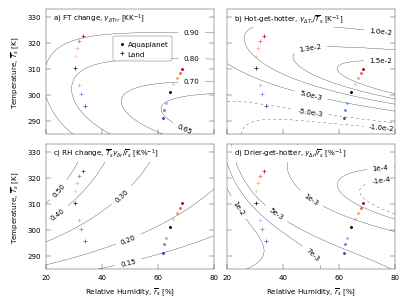

In [18]:
gamma_plot_levels = {'temp_ft_change': np.asarray([0.65, 0.7, 0.8, 0.9]),
                     'r_change': np.asarray([0.15, 0.2, 0.3, 0.4, 0.5]),
                     'cape_change': np.asarray([11, 13, 15, 16]),
                     'temp_anom': {'pos': np.asarray([0.005, 0.01, 0.013, 0.015]),
                                   'neg': np.asarray([-0.01, -0.005])},
                     'r_anom': {'pos': np.asarray([0.0001, 0.001, 0.005, 0.007, 0.01]),
                                'neg': np.asarray([-0.0001])}}
gamma_plot_labels = {'temp_ft_change': '$\gamma_{\delta T_{FT}}$ [KK$^{-1}$]',
                     'r_change': '$\overline{T}_s\gamma_{\delta r}/\overline{r}_s$ [K%$^{-1}$]',
                     'temp_anom': '$\gamma_{\Delta T_s}/\overline{T}_s$ [K$^{-1}$]',
                     'r_anom': '$\gamma_{\Delta r}/\overline{r}_s$ [%$^{-1}$]'}
# Make sure gamma prefactor has RH in units of % when dividing
gamma_prefactor = {'temp_ft_change': 1, 'r_change': temp_gamma_plot[:, np.newaxis]/(rh_gamma_plot[np.newaxis]*100),
                   'temp_anom': 1/temp_gamma_plot[:, np.newaxis], 'r_anom': 1/(rh_gamma_plot[np.newaxis]*100)}
# Manually position each contour label so does not overlap with title
clabel_pos = {'temp_ft_change': [(72, 320), (72, 310), (72, 305), (70, 288)],
              'r_change': [(25, 315), (25, 305), (50, 310), (50, 295), (50, 285)],
              'temp_anom': {'pos': [(75, 325), (50, 315), (75, 312), (50, 300)],
                            'neg': [(50, 295), (75, 285)]},
              'r_anom': {'pos': [(23, 308), (50, 290), (40, 310), (50, 312), (75, 322)],
                          'neg': [(75, 320)]}}


save_gamma_fig = True
import matplotlib.ticker as ticker
def sci_no_leading_zero(x, _, n_decimal=None):
    if n_decimal == 1:
        return f"{x:.1e}".replace("e+0", "e").replace("e+","e").replace("e0","e0").replace("e-0", "e-")
    elif n_decimal is None:
        return f"{x:.0e}".replace("e+0", "e").replace("e+","e").replace("e0","e0").replace("e-0", "e-")
# fmt = ticker.FuncFormatter(lambda x, _: f"{x:.1e}")
fmt_no_decimal = ticker.FuncFormatter(lambda x, _: sci_no_leading_zero(x, _, None))
fmt_decimal = ticker.FuncFormatter(lambda x, _: sci_no_leading_zero(x, _, 1))
fmt = {'temp_ft_change': None, 'r_change': None, 'temp_anom': fmt_decimal, 'r_anom': fmt_no_decimal}

fig, ax = plt.subplots(2,2, sharex=True, sharey=True)
fig_resize(fig, width['two_thirds'])
ax = ax.transpose().flatten()
keys_plot = [key for key in gamma_plot_levels if ('cape' not in key)]
for j, key in enumerate(keys_plot):
    if j <int(np.ceil(len(ax)/2)):
        ax[j].set_ylabel('Temperature, $\overline{T}_s$ [K]')
    # ax[j].set_title(labels_cont[key]+', '+gamma_plot_labels[key])
    ax[j].spines['right'].set_visible(True)
    ax[j].spines['top'].set_visible(True)
    # ax[j].xaxis.set_ticks_position('both')
    ax[j].yaxis.set_ticks_position('both')
    ax[j].tick_params(axis='both', direction='in')
    for key2 in plot_info:
        if np.average(plot_info[key2]['r_av'], axis=1, weights=lat_weights)[0] == 0:
            continue
        for k in range(n_kappa):
            ax[j].scatter(np.average(plot_info[key2]['r_av'], axis=1, weights=lat_weights)[k]*100,
                          np.average(plot_info[key2]['temp_s_av'], axis=1, weights=lat_weights)[k],
                  color=colors_kappa[k], marker='+' if key2=='land' else '.', label=key2.capitalize() if k==ind_kappa1_5 else None, s=marker_sz_publish)

    var = gamma[key] * gamma_prefactor[key]
    if isinstance(gamma_plot_levels[key], dict):
        var_plot = ax[j].contour(rh_gamma_plot*100, temp_gamma_plot, np.where(var < 0, np.nan, var),
                                    levels=gamma_plot_levels[key]['pos'], colors='black', linewidths=lw_contour)
        ax[j].clabel(var_plot, inline=True, fontsize=fontsize_contour, fmt=fmt[key], manual=clabel_pos[key]['pos'])
        var_plot = ax[j].contour(rh_gamma_plot*100, temp_gamma_plot, np.where(var > 0, np.nan, var),
                                    levels=gamma_plot_levels[key]['neg'], colors='black', linewidths=lw_contour)
        ax[j].clabel(var_plot, inline=True, fontsize=fontsize_contour, fmt=fmt[key], manual=clabel_pos[key]['neg'])
        for collection in var_plot.collections:
            # For negative values, increase dash separation, to emphasize negative
            collection.set_linestyle('--')  # Dotted line style
            collection.set_dashes([(0, (10.0, 10.0))])
    else:
        var_plot = ax[j].contour(rh_gamma_plot*100, temp_gamma_plot, var,
                                    levels=gamma_plot_levels[key], colors='black', linewidths=lw_contour)
        clabels = ax[j].clabel(var_plot, inline=True, fontsize=fontsize_contour, fmt=fmt[key], manual=clabel_pos[key])
    # if key == 'r_change':
    #     clabels[-1].set_position((clabels[-1].get_position()[0], clabels[-1].get_position()[1] - 5.5))  # adjust y down
if show_cape_subplot:
    ax[-1].remove()
    ax[2].set_xlabel('Relative Humidity, $\overline{r}_s$ [%]')
    ax[-2].set_xlabel('Relative Humidity, $\overline{r}_s$ [%]')
else:
    ax[1].set_xlabel('Relative Humidity, $\overline{r}_s$ [%]')
    ax[-1].set_xlabel('Relative Humidity, $\overline{r}_s$ [%]')
# Put titles in letter labels to avoid looking like x axis labels
letter_order = ['a', 'c', 'e', 'b', 'd'] if show_cape_subplot else ['a', 'c', 'b', 'd']
label_subplots(fig, ax[:4+int(show_cape_subplot)],
               [f"{letter_order[i]}) " + labels_cont[key]+', '+gamma_plot_labels[key] for i, key in enumerate(keys_plot)],
               box_alpha=1, pos_y=-2)
var = add_legend(ax[0], frameon=True, borderpad=0.05, handletextpad=0.05)
var.get_frame().set_linewidth(ax_linewidth)
var.set_bbox_to_anchor((0.78, 0.83))
update_fontsize(fig)
# update_linewidth(fig)
plt.subplots_adjust(wspace=0.08, hspace=0.08)

if use_land_evap:
    plt.close()         # if fixed evap dataset, don't need this figure
else:
    plt.show()
    if save_gamma_fig or save_fig:
        isca_tools.savefig(fig, 'sensitivity', dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches,
                           save_if_exists=False)

In [19]:
def get_gradient(temp_quant, temp_ref, ref_ind, confidence=0.9):
    """
    Gets gradient of temperature of given quantile vs average temperature

    Args:
        temp_quant: [n_exp]
            Temperature of given quantile for each experiment
        temp_ref: [n_exp]
            Reference temperature for each experiment
        ref_ind: int
            Regression line will go through (temp_ref[ref_ind], temp_quant[ref_ind])
            I.e. it sets the intercept
        confidence: float
            Desired confidence in temperature

    Returns:
        float
            Gradient K/K
        [n_exp]
            Predicted temperature for each experiment
        float
            Confidence value for the gradient, such that there is the desired confidence
            in ± this value about returned gradient.
    """
    fit_func = lambda x, m: temp_quant[ref_ind] + m*(x - temp_ref[ref_ind])     # Straight line through the ref point
    param, pcov = scipy.optimize.curve_fit(fit_func, temp_ref, temp_quant)[:2]
    # param_with_error = uncertainties.correlated_values(param, pcov)[0]
    # param_std = param_with_error.std_dev
    param_std = np.sqrt(pcov)
    z_score = z_score_from_confidence_interval(confidence)
    return param, fit_func(temp_ref, param), z_score * param_std

### Figure - Variable Contribution to each mechanism
The scaling factor has 6 mechanisms, each can be broken down into a variable that varies in $\chi[x]$, and a sensitivity parameter $\gamma$. The $\gamma$ values are plotted above, and here we plot $\chi[x]$.

We combine simulations, so have 4 lines: cold and hot simulations for both land and aquaplanet.
This enables us to see which mechanisms become more important in a hotter climate.

In [20]:
if not load_data:
    # Get variable as function of x responsible for each mechanism
    delta_temp_quant_theory_var = {key: np.zeros((n_kappa, n_lat, n_quant)) for key in
                                   ['temp_ft_change', 'r_change', 'cape_change', 'temp_anom', 'r_anom', 'cape_anom', 'cape_sim_change',
                                    'cape_sim_anom', 'klzbs_quant3']}
    for i in range(n_lat):
        for j in range(n_kappa-1):
            # For anom mechanisms, just take anom and multiply by temp_s difference
            delta_temp_quant_theory_var['temp_anom'][j+1, i] = (temp_quant3[j, ind_surf, i] -
                                                                temp_surf_ref[j, i]) * np.diff(temp_surf_ref[j:j+2, i], axis=0)
            delta_temp_quant_theory_var['r_anom'][j+1, i] = (r_quant3[j, i] -
                                                             r_ref[j, i, 0]) * np.diff(temp_surf_ref[j:j+2, i], axis=0) * 100
            delta_temp_quant_theory_var['cape_sim_anom'][j+1, i] = (cape_sim_quant3[j, i] -
                                                                    cape_sim_ref[j, i]) * np.diff(temp_surf_ref[j:j + 2, i], axis=0)
            delta_temp_quant_theory_var['cape_anom'][j+1, i] = (cape_quant3[j, i] -
                                                                cape_ref[j, i]) * np.diff(temp_surf_ref[j:j + 2, i], axis=0)
            delta_temp_quant_theory_var['klzbs_quant3'][j+1, i] = klzbs_quant3[j, i] * np.diff(temp_surf_ref[j:j + 2, i], axis=0)
            # For change mechanisms, just add change of the actual variable
            delta_temp_quant_theory_var['temp_ft_change'][j+1, i] = np.diff(temp_quant3[j:j+2, ind_ft, i], axis=0)
            delta_temp_quant_theory_var['r_change'][j+1, i] = np.diff(r_quant3[j:j+2, i], axis=0) * 100
            delta_temp_quant_theory_var['cape_change'][j+1, i] = np.diff(cape_quant3[j:j+2, i], axis=0)
            delta_temp_quant_theory_var['cape_sim_change'][j+1, i] = np.diff(cape_sim_quant3[j:j + 2, i], axis=0)
    for key in [key for key in delta_temp_quant_theory_var if 'cape' in key]:
        delta_temp_quant_theory_var[key] *= 1000        # convert into J/kg
    temp_surf_quant3_theory_var = {key: np.cumsum(delta_temp_quant_theory_var[key], axis=0) for key in delta_temp_quant_theory_var}

In [21]:
# Consider 3 different groups of simulations: all; all below kappa=1. all above kappa=1
if load_data:
    n_sf = plot_info['land']['sf_tau_use'].shape[0]
    sf_tau_use = [np.where(plot_info['land']['sf_tau_use'][i])[0] for i in range(n_sf)]
else:
    sf_tau_use = [np.where(tau_lw<=np.inf)[0], np.where(tau_lw<=1.5)[0], np.where(tau_lw>=1.5)[0]]
    sf_tau_ref = np.asarray([1.5, 1.5, 1.5])
    n_sf = len(sf_tau_use)
    sf_tau_ref_ind = [int(np.where(tau_lw[sf_tau_use[i]]==sf_tau_ref[i])[0]) for i in range(n_sf)]

    # Save tau range to fig data
    for key in ['aquaplanet', 'land']:
        try:
            plot_info[key]['sf_tau_use']       # just to check if key exists
        except KeyError:
            # If variable doesn't exist, create it with all values set to 0
            plot_info[key]['sf_tau_use'] = np.zeros((n_sf, n_kappa), dtype=bool)
        try:
            plot_info[key]['sf_tau_ref']       # just to check if key exists
        except KeyError:
            # If variable doesn't exist, create it with all values set to 0
            plot_info[key]['sf_tau_ref'] = np.zeros(n_sf)

    plot_info['land' if is_land_data else 'aquaplanet']['sf_tau_use'] = np.asarray([[i in sf_tau_use[j] for i in np.arange(n_kappa)]
                                                                                    for j in range(n_sf)])
    plot_info['land' if is_land_data else 'aquaplanet']['sf_tau_ref'] = sf_tau_ref
sf_labels = [f'${tau_lw[sf_tau_use[0]].min()} \leq \kappa \leq {tau_lw[sf_tau_use[0]].max()}$',
             f'$\kappa \leq {tau_lw[sf_tau_use[1]].max()}$',
             f'$\kappa \geq {tau_lw[sf_tau_use[2]].min()}$']

In [22]:
if not load_data:
    scaling_factor_theory_var = {key: np.zeros((n_sf, n_lat, n_quant)) for key in delta_temp_quant_theory_var}
    with tqdm(total=n_sf*n_lat*n_quant, position=0, leave=True) as pbar:
        for i in range(n_sf):
            for j in range(n_quant):
                for k in range(n_lat):
                    for key in scaling_factor_theory_var:
                        scaling_factor_theory_var[key][i, k, j] = get_gradient(temp_surf_quant3_theory_var[key][sf_tau_use[i], k, j],
                                                                              temp_surf_ref[sf_tau_use[i], k],
                                                                              sf_tau_ref_ind[i])[0]
                    pbar.update(1)

In [23]:
# Combine data required for plotting from aquaplanet and land into 1 dictionary
# Need to run through notebook twice (one with aquaplanet data loaded, one with land data loaded) to get final dict
if not load_data:
    for key in ['aquaplanet', 'land']:
        try:
            plot_info[key]['sf_theory_var']       # just to check if key exists
        except KeyError:
            # If variable doesn't exist, create it with all values set to 0
            plot_info[key]['sf_theory_var'] = {key2: np.zeros_like(scaling_factor_theory_var[key2]) for key2 in scaling_factor_theory_var}

    for key in scaling_factor_theory_var:
        plot_info['land' if is_land_data else 'aquaplanet']['sf_theory_var'][key][:] = scaling_factor_theory_var[key]

In [24]:
def move_axis_to_center(ax):
    # Get positions of original left and right bottom subplots
    pos_left = ax[2, 0].get_position()
    pos_right = ax[1, 1].get_position()  # any other plot in same column to get width

    # Compute center of the row
    row_center = (pos_left.x0 + pos_right.x0 + pos_right.width) / 2
    new_x0 = row_center - pos_left.width / 2

    # Move the bottom-left subplot to row center
    ax[2, 0].set_position([new_x0, pos_left.y0, pos_left.width, pos_left.height])

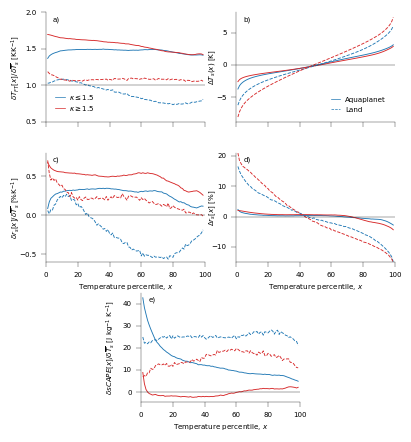

In [25]:
colors_sf_tau = ['k', default_colors[0], default_colors[3]]
linestyles_surf = {'aquaplanet': '-', 'land': '--'}
labels_var = {'temp_ft_change': '$\delta T_{FT}[x]/\delta \overline{T}_s$ [KK$^{-1}$]',
              'r_change': '$\delta r_s[x]/\delta \overline{T}_s$ [%K$^{-1}$]',
              'cape_change': '$\delta sCAPE[x]/\delta \overline{T}_s$ [J kg$^{-1}$ K$^{-1}$]',
              'temp_anom': '$\Delta T_s(x)$ [K]', 'r_anom': '$\Delta r_s[x]$ [%]'}

save_sf_theory_var_fig = False
fig, ax = plt.subplots(3,2, sharex=True)
fig_resize(fig, width['two_thirds'], ar=ar)
ax[2, 1].remove()
plt.subplots_adjust(hspace=0.28)
move_axis_to_center(ax)
label_subplots(fig, ax.flatten(), box_alpha=0, pos_y=-3)
ax = ax.transpose().flatten()
for k, key in enumerate(labels_var):
    for j, key2 in enumerate(plot_info):
        for i in range(1, 3):
            if k == 0:
                label_use = sf_labels[i] if j==0 else None
            else:
                label_use = key2.capitalize() if i==1 else None
            ax[k].plot(quant_plot, np.average(plot_info[key2]['sf_theory_var'][key][i], axis=0, weights=lat_weights),
                       color=colors_sf_tau[i], linestyle=linestyles_surf[key2], label=label_use)
    ax[k].set_ylabel(labels_var[key])
    ax[k].yaxis.set_label_coords(-0.115 if 'anom' in key else -0.15, 0.5)     # manually move y label as negative value causes it to be too far away
    if 'temp' not in key:
        ax[k].set_xlabel('Temperature percentile, $x$')
        ax[k].xaxis.set_label_coords(0.5, -0.18)
# ax[2].set_ylim(0, ax[2].get_ylim()[1])
ax[0].set_ylim(0.5, 2)
# ax[0].set_yticks(np.arange(0.5, 2.5, 0.5))      # change tick frequency
# ax[4].yaxis.set_label_coords(-0.11, 0.5)
ylim_rh = {'change': [-0.6, 0.8], 'anom': [-15, 21]}                # use for this and fixed evap plot below
ytick_rh = {'change': [-0.5, 0, 0.5], 'anom': [-10, 0, 10, 20]}     # use for this and fixed evap plot below
ax[1].set_ylim(ylim_rh['change'])
ax[4].set_ylim(ylim_rh['anom'])
ax[1].set_yticks(ytick_rh['change'])
ax[4].set_yticks(ytick_rh['anom'])
add_legend(ax[0], loc='lower left')
add_legend(ax[3], loc='lower right')
# ax[2].set_xlabel('Temperature percentile, $x$')
# ax[-2].set_xlabel('Temperature percentile, $x$')
ax[0].set_xlim(0, 100)
ax[1].set_ylim()
update_fontsize(fig)
update_linewidth(fig)
ax[0].axhline(1, color='k', lw=ax_linewidth)
for k, key in enumerate(labels_var):
    if key not in ['temp_ft_change', 'epsilon_change']:
        ax[k].axhline(0, color='k', lw=ax_linewidth)
ax[1].xaxis.set_tick_params(labelbottom=True)
ax[-2].xaxis.set_tick_params(labelbottom=True)      # add xtick labels for bottom right axis
if use_land_evap:
    plt.close()         # if fixed evap dataset, don't need this figure
else:
    plt.show()
    if save_sf_theory_var_fig or save_fig:
        isca_tools.savefig(fig, 'sf_theory_var', dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches,
                           save_if_exists=False)

### Figure - CAPE
This figure is equivalent to *e)* and *f)* above, except for CAPE. The idea is to show that the two plots are similar indicating $\epsilon$ is a good proxy for CAPE.

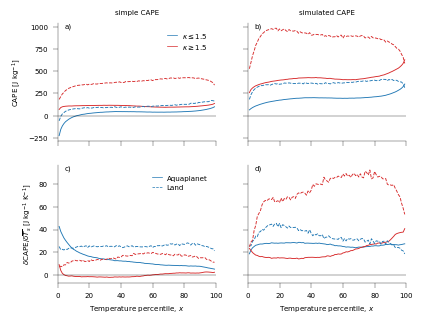

In [26]:
save_cape_fig = False
fig, ax = plt.subplots(2,2, sharex=True, sharey='row')
fig_resize(fig, width['two_thirds'], ar=ar)
labels_cape = ['CAPE [J kg$^{-1}$]', '$\delta $CAPE$/\delta \overline{T}_s$ [J kg$^{-1}$ K$^{-1}$]']
for k, key in enumerate(['anom', 'change']):
    for j, key2 in enumerate(plot_info):
        for i in range(1, 3):
            if k == 0:
                label_use = sf_labels[i] if j==0 else None
            else:
                label_use = key2.capitalize() if i==1 else None
            ax[k, 0].plot(quant_plot, np.average(plot_info[key2]['sf_theory_var']['cape_'+key][i], axis=0, weights=lat_weights),
                       color=colors_sf_tau[i], linestyle=linestyles_surf[key2], label=label_use)
            ax[k, 1].plot(quant_plot, np.average(plot_info[key2]['sf_theory_var']['cape_sim_'+key][i], axis=0, weights=lat_weights),
                       color=colors_sf_tau[i], linestyle=linestyles_surf[key2], label=label_use)
    ax[k, 0].set_ylabel(labels_cape[k])
ax[0, 0].set_title('simple CAPE')
ax[0, 1].set_title('simulated CAPE')
# ax[0].set_ylim(0, 0.1)
# ax[1].set_ylim(0, 1)
legend = add_legend(ax[0, 0], loc='upper right')
# legend.set_bbox_to_anchor((1.02, -0.03))
legend = add_legend(ax[1, 0], loc='upper right')
# legend.set_bbox_to_anchor((1.02, -0.03))
ax[1, 0].set_xlabel('Temperature percentile, $x$')
ax[1, 1].set_xlabel('Temperature percentile, $x$')
ax[0, 0].set_xlim(0, 100)
label_subplots(fig, ax.flatten(), box_alpha=0, pos_y=0)
ax[1, 0].yaxis.set_label_coords(-0.15, 0.5)
# plt.subplots_adjust(wspace=0.28)
update_linewidth(fig)
update_fontsize(fig)
for ax_use in ax.flatten():
    ax_use.axhline(0, color='k', lw=ax_linewidth)
if use_land_evap:
    plt.close()         # if fixed evap dataset, don't need this figure
else:
    plt.show()
    if save_cape_fig or save_fig:
        isca_tools.savefig(fig, 'cape', dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches,
                           save_if_exists=False)

### Level of Neutral Buoyancy
Look into level of neutral buoyancy to see if CAPE negative because LNB too close to surface.

Below, I print the max value of $x$, for which LNB is greater than $\sigma$ used as FT level. Indicates where framework may not be appropriate.

I think this is probably un-necessary - does not tell you much more than the bottom left plot above.

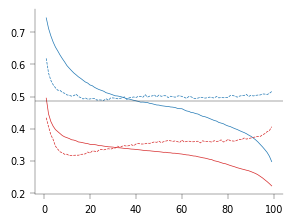

In [27]:
# sigma levels starts with 0 (space), ends near 1 (surface) like pfull does in ds
sigma_from_level_func = scipy.interpolate.interp1d(np.arange(len(sigma_levels_full)), sigma_levels_full)
def lzb(k, interp_func=sigma_from_level_func):
    # Offset by -1 because fortran starts with 1, but python starts with 0
    # ds.t_ref will match exactly ds.temp if -2 used as offset, but this is not the LNB.
    if np.size(k) == 1:
        return float(interp_func(np.clip(k-1, 0, np.inf)))
    else:
        return interp_func(np.clip(k-1, 0, np.inf))
fig, ax = plt.subplots(1,1, sharex=True, sharey='row')
fig_resize(fig, width['one_col'], ar=ar)
for j, key2 in enumerate(plot_info):
    for i in range(1, 3):
        if k == 0:
            label_use = sf_labels[i] if j==0 else None
        else:
            label_use = key2.capitalize() if i==1 else None
        ax.plot(quant_plot, lzb(np.average(plot_info[key2]['sf_theory_var']['klzbs_quant3'][i], axis=0, weights=lat_weights)),
                   color=colors_sf_tau[i], linestyle=linestyles_surf[key2], label=label_use)
ax.axhline(sigma_levels_full[np.argmin(np.abs(sigma_levels_full-pressure_ft_actual/10**5))], color='k', lw=ax_linewidth)

In [28]:
if not load_data:
    var_px_change_decomp = {key: {key2: np.zeros((n_kappa-1, n_lat, n_quant)) for key2 in ['temp_ft_change', 'r_change', 'cape_change']}
                            for key in ['dist', 'p_x']}
    for i in range(n_kappa-1):
        for j in range(n_lat):
            var_use = decompose_var_x_change(temp_quant3[i:i+2, ind_ft, j],
                                             temp_ft_quant[i:i+2, j], quant_px, simple=False)[2]
            for key2 in ['dist', 'p_x']:
                var_px_change_decomp[key2]['temp_ft_change'][i, j] = var_use[key2]
            var_use = decompose_var_x_change(r_quant3[i:i+2, j],
                                             r_quant[i:i+2, j], quant_px, simple=False)[2]
            for key2 in ['dist', 'p_x']:
                var_px_change_decomp[key2]['r_change'][i, j] = var_use[key2]

            # For cape, in aquaplanet quick method can have cape_quant.min() larger than cape_quant3.min() - deal with that here
            var_use = cape_quant[i:i+2, j] * 1
            for k in range(2):
                if cape_quant3[i+k, j].min() < cape_quant[i+k, j].min():
                    warnings.warn(f'i={i+k}, j={j}: cape in cape_quant3 lower than in cape_quant; changing cape_quant[0] to cape_quant3[0]')
                    var_use[k, 0] = cape_quant3[i+k, j].min()
                if cape_quant3[i+k, j].max() > cape_quant[i+k, j].max():
                    warnings.warn(f'i={i+k}, j={j}: cape in cape_quant3 larger than in cape_quant; changing cape_quant[-1] to cape_quant3[-1]')
                    var_use[k, -1] = cape_quant3[i+k, j].max()
            var_use = decompose_var_x_change(cape_quant3[i:i+2, j],
                                             var_use, quant_px, simple=False)[2]

            for key2 in ['dist', 'p_x']:
                var_px_change_decomp[key2]['cape_change'][i, j] = var_use[key2]

In [29]:
if not load_data:
    # delta_temp_quant_theory[0] will be all zeros and never used, but helpful to keep this shape
    delta_temp_quant_theory = {method: np.zeros((n_kappa, n_lat, n_quant)) for method in
                               ['linear', 'non-linear', 'p_x', 'numerical']}
    delta_temp_quant_theory_cont = {key: np.zeros((n_kappa, n_lat, n_quant)) for key in ['temp_ft_change', 'r_change', 'cape_change',
                                                                                         'temp_anom', 'r_anom', 'temp_ft_change_no_lapse',
                                                                                         'temp_ft_change_dist', 'temp_ft_change_p_x', 'r_change_dist',
                                                                                         'r_change_p_x', 'cape_change_dist', 'cape_change_p_x']}
    delta_temp_quant_theory_numerical_cont = {key: np.zeros((n_kappa, n_lat, n_quant)) for key in
                                              ['r_ref_change', 'epsilon_ref_change', 'z_approx_ref_change', 'temp_ft_change', 'r_change',
                                               'epsilon_change', 'z_approx_change', 'temp_anom', 'r_anom', 'epsilon_anom', 'z_approx_anom']}
    delta_temp_quant_theory_approx = {key: np.zeros((n_kappa, n_lat, n_quant)) for key in
                                      ['temp_ft_anom_change', 'temp_s_anom_change', 'r_change', 'temp_s_anom_r_change', 'anom_temp_s_r',
                                       'anom', 'ref_change', 'z_anom_change', 'nl', 'cape']}

    for i in range(n_lat):
        for j in range(n_kappa-1):
            for method in ['non-linear', 'linear']: # have linear as second, so var is from linear method
                delta_temp_quant_theory[method][j+1, i], gamma_use, _, var = \
                        get_scale_factor_theory(temp_surf_ref[j:j+2, i], temp_quant3[j:j+2, ind_surf, i], r_ref[j, i], r_quant3[j:j+2, i],
                                                temp_quant3[j:j+2, ind_ft, i], epsilon_quant3[j:j+2, i], p_surface,
                                                pressure_ft_actual, epsilon_ref[j:j+2, i], z_approx_error_ref[j:j+2, i],
                                                include_non_linear=True if method=='non-linear' else False, cape_form=True)
                delta_temp_quant_theory[method][j+1, i] *= np.diff(temp_surf_ref[j:j+2, i], axis=0)
            for key in delta_temp_quant_theory_cont:
                if key == 'temp_ft_change_no_lapse':
                    # Approx contribution from ft_change on scale factor if dT/dz remains constant
                    delta_temp_quant_theory_cont[key][j+1, i] = temp_surf_ref[j, i]/temp_av[av_use][j, ind_ft, i] * \
                                                                np.diff(temp_quant3[j:j+2, ind_ft, i], axis=0)
                # Deal with p_x decomposition stuff
                elif '_dist' in key:
                    delta_temp_quant_theory_cont[key][j+1, i] = gamma_use[key.replace('_dist', '')] * \
                                                                var_px_change_decomp['dist'][key.replace('_dist', '')][j, i]
                elif '_p_x' in key:
                    delta_temp_quant_theory_cont[key][j+1, i] = gamma_use[key.replace('_p_x', '')] * \
                                                                var_px_change_decomp['p_x'][key.replace('_p_x', '')][j, i]
                else:
                    delta_temp_quant_theory_cont[key][j+1, i] = var[key] * np.diff(temp_surf_ref[j:j+2, i], axis=0)
                # Deal with prefactor required for gamma to be positive and non-dimensional for p_x decomposition
                if key in ['r_change_dist', 'r_change_p_x']:
                    delta_temp_quant_theory_cont[key][j+1, i] *= -temp_surf_ref[j, i]/r_ref[j, i, 0]
                if key in ['cape_change_dist', 'cape_change_p_x']:
                    delta_temp_quant_theory_cont[key][j+1, i] *= 1000/R_mod   # remember epsilon used is in kJ/kg so x1000
                delta_temp_quant_theory['p_x'][j+1, i] = sum([delta_temp_quant_theory_cont[key][j+1, i] for key in delta_temp_quant_theory_cont
                                                              if key not in ['temp_ft_change', 'r_change', 'cape_change', 'temp_ft_change_no_lapse']])
            # Get approx info
            var = get_approx_terms(temp_surf_ref[j:j+2, i], temp_quant3[j:j+2, ind_surf, i], r_ref[j, i], r_quant3[j:j+2, i],
                                   temp_quant3[j:j+2, ind_ft, i], epsilon_quant3[j:j+2, i], p_surface, pressure_ft_actual,
                                   epsilon_ref[j:j+2, i], z_approx_error_ref[j:j+2, i], cape_form=True)[0]
            for key in delta_temp_quant_theory_approx:
                delta_temp_quant_theory_approx[key][j+1, i] = var[key] * np.diff(temp_surf_ref[j:j+2, i], axis=0)

            # Numerical theory
            delta_temp_quant_theory['numerical'][j+1, i], var = \
                        get_scale_factor_theory_numerical(temp_surf_ref[j:j+2, i], temp_quant3[j:j+2, ind_surf, i], r_ref[j, i], r_quant3[j:j+2, i],
                                                temp_quant3[j:j+2, ind_ft, i], epsilon_quant3[j:j+2, i], p_surface,
                                                pressure_ft_actual, epsilon_ref[j:j+2, i], z_approx_error_ref[j:j+2, i])
            delta_temp_quant_theory['numerical'][j+1, i] *= np.diff(temp_surf_ref[j:j+2, i], axis=0)
            for key in delta_temp_quant_theory_numerical_cont:
                # Scaling factor for temp_ft_change should be around 1, whereas all other mechanisms should be around 0
                delta_temp_quant_theory_numerical_cont[key][j+1, i] = (var[key] - (0 if key =='temp_ft_change' else 1)
                                                                       ) * np.diff(temp_surf_ref[j:j+2, i], axis=0)
    temp_surf_quant3_theory = {method: temp_quant3[0, ind_surf] + np.cumsum(delta_temp_quant_theory[method], axis=0) for method in delta_temp_quant_theory}
    temp_surf_quant3_theory_cont = {key: np.cumsum(delta_temp_quant_theory_cont[key], axis=0) for key in delta_temp_quant_theory_cont}
    temp_surf_quant3_theory_approx = {key: np.cumsum(delta_temp_quant_theory_approx[key], axis=0) for key in delta_temp_quant_theory_approx}
    temp_surf_quant3_theory_numerical_cont = {key: np.cumsum(delta_temp_quant_theory_numerical_cont[key], axis=0) for key in
                                              delta_temp_quant_theory_numerical_cont}

In [30]:
# Sanity check that theory is working
if not load_data:
    show_plot = False
    plot_lat_ind = -5
    plot_quant_ind = -93

    fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
    ax.plot(temp_surf_ref[:, plot_lat_ind], temp_quant3[:, ind_surf, plot_lat_ind, plot_quant_ind], color='k', marker='o', label='Simulated')
    ax.plot(temp_surf_ref[:, plot_lat_ind], temp_surf_quant3_theory['linear'][:, plot_lat_ind, plot_quant_ind], color='k', linestyle=':', label='Theory')
    ax.set_xlabel('$\overline{T}_s$ [K]')
    ax.set_ylabel(f'$T_s(x={quant_plot[plot_quant_ind]})$ [K]')
    ax.legend()
    ax.set_title('Lat={:.2f}$\degree$'.format(ds_all[0].lat[plot_lat_ind]))
    if show_plot:
        plt.show()
    else:
        plt.close()

### Figure - Scaling Factor
Here we show the scaling factor, and two versions of the theory. One is the linear version, and the second is the linear version if we break down the change mechanisms into distribution change and percentile change contributions.

In [31]:
# Consider 3 different groups of simulations: all; all below kappa=1. all above kappa=1
if not load_data:
    scaling_factor = np.zeros((n_sf, n_lat, n_quant))
    scaling_factor_theory = {method: np.zeros((n_sf, n_lat, n_quant)) for method in delta_temp_quant_theory}
    scaling_factor_theory_cont = {key: np.zeros((n_sf, n_lat, n_quant)) for key in delta_temp_quant_theory_cont}
    scaling_factor_theory_approx = {key: np.zeros((n_sf, n_lat, n_quant)) for key in delta_temp_quant_theory_approx}
    scaling_factor_theory_numerical_cont = {key: np.zeros((n_sf, n_lat, n_quant)) for key in delta_temp_quant_theory_numerical_cont}

    with tqdm(total=n_sf*n_lat*n_quant, position=0, leave=True) as pbar:
        for i in range(n_sf):
            for j in range(n_quant):
                # The theory predicts median change but not mean hence I use median rather than mean.
                # This means can get theoretical scale factor rather than using simulated mean.
                # This means x=50 will correspond to y=1 in all plots below.
                # Straight line through the ref point
                for k in range(n_lat):
                    scaling_factor[i, k, j] = get_gradient(temp_quant3[sf_tau_use[i], ind_surf, k, j],
                                                           temp_surf_ref[sf_tau_use[i], k], sf_tau_ref_ind[i])[0]
                    for method in scaling_factor_theory:
                        scaling_factor_theory[method][i, k, j] = get_gradient(temp_surf_quant3_theory[method][sf_tau_use[i], k, j],
                                                                              temp_surf_ref[sf_tau_use[i], k],
                                                                              sf_tau_ref_ind[i])[0]
                    for key in scaling_factor_theory_cont:
                        scaling_factor_theory_cont[key][i, k, j] = get_gradient(temp_surf_quant3_theory_cont[key][sf_tau_use[i], k, j],
                                                                              temp_surf_ref[sf_tau_use[i], k],
                                                                              sf_tau_ref_ind[i])[0]
                    for key in scaling_factor_theory_approx:
                        scaling_factor_theory_approx[key][i, k, j] = get_gradient(temp_surf_quant3_theory_approx[key][sf_tau_use[i], k, j],
                                                                              temp_surf_ref[sf_tau_use[i], k],
                                                                              sf_tau_ref_ind[i])[0]
                    for key in scaling_factor_theory_numerical_cont:
                        scaling_factor_theory_numerical_cont[key][i, k, j] = \
                            get_gradient(temp_surf_quant3_theory_numerical_cont[key][sf_tau_use[i], k, j], temp_surf_ref[sf_tau_use[i], k],
                                         sf_tau_ref_ind[i])[0]
                    pbar.update(1)

In [32]:
# Combine data required for plotting from aquaplanet and land into 1 dictionary
# Need to run through notebook twice (one with aquaplanet data loaded, one with land data loaded) to get final dict

# arrays below are just all zero with correct size to initialise plot_info entries
if not load_data:
    zero_plot_info_arrays = {'sf': np.zeros_like(scaling_factor),
                             'sf_theory': {key2: np.zeros_like(scaling_factor_theory[key2]) for key2 in scaling_factor_theory},
                             'sf_theory_cont': {key2: np.zeros_like(scaling_factor_theory_cont[key2]) for key2 in scaling_factor_theory_cont},
                             'sf_theory_approx': {key2: np.zeros_like(scaling_factor_theory_approx[key2]) for key2 in scaling_factor_theory_approx},
                             'sf_theory_numerical_cont': {key2: np.zeros_like(scaling_factor_theory_numerical_cont[key2]) for key2 in
                                                          scaling_factor_theory_numerical_cont}}
    for key in ['aquaplanet', 'land']:
        for key2 in ['sf', 'sf_theory', 'sf_theory_cont', 'sf_theory_approx', 'sf_theory_numerical_cont']:
            try:
                plot_info[key][key2]       # just to key exists
            except KeyError:
                # If variable doesn't exist, create it with all values set to 0
                plot_info[key][key2] = copy.deepcopy(zero_plot_info_arrays[key2])

    # Update plot dict for current loaded simulation
    plot_info['land' if is_land_data else 'aquaplanet']['sf'][:] = scaling_factor
    for key in scaling_factor_theory:
        plot_info['land' if is_land_data else 'aquaplanet']['sf_theory'][key][:] = scaling_factor_theory[key]
    for key in scaling_factor_theory_cont:
        plot_info['land' if is_land_data else 'aquaplanet']['sf_theory_cont'][key][:] = scaling_factor_theory_cont[key]
    for key in scaling_factor_theory_approx:
        plot_info['land' if is_land_data else 'aquaplanet']['sf_theory_approx'][key][:] = scaling_factor_theory_approx[key]
    for key in scaling_factor_theory_numerical_cont:
        plot_info['land' if is_land_data else 'aquaplanet']['sf_theory_numerical_cont'][key][:] = scaling_factor_theory_numerical_cont[key]

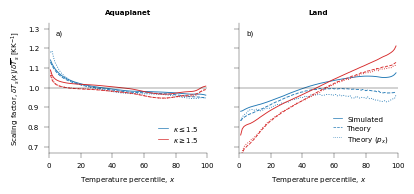

In [33]:
save_sf_theory_fig = False
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
fig_resize(fig, width['two_thirds'])
for j, key in enumerate(plot_info):
    for i in range(1, 3):
        if key=='land':
            label_use = 'Simulated' if i==1 else None
        else:
            label_use = sf_labels[i]
        ax[j].plot(quant_plot, np.average(plot_info[key]['sf'][i], axis=0, weights=lat_weights), color=default_colors[0+3*(i-1)],
                   label=label_use)
        ax[j].plot(quant_plot, np.average(plot_info[key]['sf_theory']['linear'][i], axis=0, weights=lat_weights), color=default_colors[0+3*(i-1)],
                   linestyle='--', label='Theory' if (key=='land' and i==1) else None)
        ax[j].plot(quant_plot, np.average(plot_info[key]['sf_theory']['p_x'][i], axis=0, weights=lat_weights), color=default_colors[0+3*(i-1)],
                   linestyle=':', label='Theory ($p_x$)' if (key=='land' and i==1) else None)
        # ax[j].plot(quant_plot, np.average(scaling_factor_theory['non-linear'][i], axis=0, weights=lat_weights), color=default_colors[0+3*(i-1)],
        #     linestyle=':', label='Theory (non-linear)' if (is_land_data and i==1) else None)

    ax[j].set_xlabel('Temperature percentile, $x$')
    add_legend(ax[j], loc='lower right')
    ax[j].set_title(key.capitalize(), fontweight='bold')
ax[0].set_xlim(0,100)
ylim_sf = [0.67, 1.33]                    # use here and for fixed evap figure below
ytick_sf = np.arange(0.7, 1.4, 0.1)     # use here and for fixed evap figure below
ax[0].set_ylim(ylim_sf)
ax[0].set_yticks(ytick_sf)
label_subplots(fig, ax)
ax[0].set_ylabel('Scaling factor, $\delta T_s(x)/\delta \overline{T}_s$ [KK$^{-1}$]')
update_linewidth(fig)
update_fontsize(fig)
ax[0].axhline(1, linewidth=ax_linewidth, color='k')
ax[1].axhline(1, linewidth=ax_linewidth, color='k')
if use_land_evap:
    plt.close() # if fixed evap dataset, don't need this figure
else:
    plt.show()
    if save_sf_theory_fig or save_fig:
        isca_tools.savefig(fig, 'sf_theory', dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches,
                           save_if_exists=False)

## Fixed Evap Fraction Figures
### Figure - RH in fixed Evap Simulation
This is just *c)* and *d)* of the variable contribution Figure. Idea is to show RH behaves more closely to aquaplanet than land in these fixed evap simulations.

### Figure - Scaling Factor
The scaling factor figure for fixed evaporative fraction, is again to show behaviour closer to aquaplanet.

In [34]:
# Constant Evap Prefactor Land - just to show that RH does not decrease with warming, and don't have RH gradient in current climate
if use_land_evap:
    save_fixed_evap_rh_fig = False
    fig, ax = plt.subplots(1,2, sharex=True)
    fig_resize(fig, width['two_thirds'])
    # label_subplots(fig, ax.flatten(), box_alpha=0)
    # ax = ax.transpose().flatten()
    for k, key in enumerate(['r_change', 'r_anom']):
        for j, key2 in enumerate(plot_info):
            if key2 == 'aquaplanet':
                continue
            for i in range(1, 3):
                ax[k].plot(quant_plot, np.average(plot_info[key2]['sf_theory_var'][key][i], axis=0, weights=lat_weights),
                           color=colors_sf_tau[i], linestyle=linestyles_surf[key2], label=sf_labels[i])
        ax[k].set_ylabel(labels_var[key])
    # ax[1].set_ylim(ax[1].get_ylim()[0], 1)
    ax[0].legend(loc='lower left', labelspacing=leg_info['labelspacing'],
                 handlelength=leg_info['handlelength'], handletextpad=leg_info['handletextpad'])
    ax[0].set_xlabel('Temperature percentile, $x$')
    ax[-1].set_xlabel('Temperature percentile, $x$')
    ax[0].set_xlim(0, 100)
    # Ensure same y-axis as previous plot
    ax[0].set_ylim(ylim_rh['change'])
    ax[1].set_ylim(ylim_rh['anom'])
    ax[0].set_yticks(ytick_rh['change'])
    ax[1].set_yticks(ytick_rh['anom'])
    ax[0].yaxis.set_label_coords(-0.15, 0.5)
    ax[1].yaxis.set_label_coords(-0.15, 0.5)
    label_subplots(fig, ax, box_alpha=0, pos_y=0)
    plt.subplots_adjust(wspace=0.28)
    update_linewidth(fig)
    update_fontsize(fig)
    for ax_use in ax:
        ax_use.axhline(0, linewidth=ax_linewidth, color='k')
    plt.show()
    if save_fixed_evap_rh_fig or save_fig:
        isca_tools.savefig(fig, 'fixed_evap_rh', dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches,
                           save_if_exists=False)

In [35]:
# Constant Evap Prefactor Land - show sf plot to compare to aquaplanet and bucket
if use_land_evap:
    save_fixed_evap_sf_fig = False
    fig, ax = plt.subplots(1,1)
    fig_resize(fig, width['one_col'])
    for j, key in enumerate(plot_info):
        if key == 'aquaplanet':
            continue
        for i in range(1, 3):
            ax.plot(quant_plot, np.average(plot_info[key]['sf'][i], axis=0, weights=lat_weights), color=default_colors[0+3*(i-1)],
                       label='Simulated' if i==1 else None)
            ax.plot(quant_plot, np.average(plot_info[key]['sf_theory']['linear'][i], axis=0, weights=lat_weights), color=default_colors[0+3*(i-1)],
                       linestyle='--', label='Theory' if (key=='land' and i==1) else None)
            ax.plot(quant_plot, np.average(plot_info[key]['sf_theory']['p_x'][i], axis=0, weights=lat_weights), color=default_colors[0+3*(i-1)],
                       linestyle=':', label='Theory ($p_x$)' if (key=='land' and i==1) else None)
            # ax.plot(quant_plot, np.average(scaling_factor_theory['non-linear'][i], axis=0, weights=lat_weights), color=default_colors[0+3*(i-1)],
            #     linestyle=':', label='Theory (non-linear)' if (is_land_data and i==1) else None)

        ax.set_xlabel('Temperature percentile, $x$')
    # Just for legend plot lines outside range
    for i in range(1, 3):
        ax.plot([-1,-2], [0, 0], color=colors_sf_tau[i], label=sf_labels[i])
    ax.legend(loc='lower right', ncol=2, labelspacing=leg_info['labelspacing'],
              handlelength=leg_info['handlelength'], columnspacing=leg_info['columnspacing'], handletextpad=leg_info['handletextpad'])
    ax.set_xlim(0,100)
    ax.set_ylim(ylim_sf)            # same as sf plot above
    ax.set_yticks(ytick_sf)         # same as sf plot above
    ax.set_ylabel('Scaling factor, $\delta T_s(x)/\delta \overline{T}_s$ [KK$^{-1}$]')
    update_linewidth(fig)
    update_fontsize(fig)
    ax.axhline(1, linewidth=ax_linewidth, color='k')
    plt.show()
    if save_fixed_evap_sf_fig or save_fig:
        isca_tools.savefig(fig, 'fixed_evap_sf', dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches,
                           save_if_exists=False)

In [36]:
if use_land_evap:
    print(hdhfhsj) # error to stop running any further if fixed evap is current experiment, as only want to get above 2 figures.

In [37]:
if not load_data:
    plot_sf_ind_use = 0
    show_plot = False
    fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
    ax.plot(quant_plot, np.average(scaling_factor[plot_sf_ind_use], axis=0, weights=lat_weights), color='b', label='Simulated')
    ax.plot(quant_plot, np.average(scaling_factor_theory['linear'][plot_sf_ind_use], axis=0, weights=lat_weights), color='k',
            linestyle='--', label=f'Theory')
    ax.hlines(1, 0, 100, linewidth=ax_linewidth, color='k')
    ax.legend()
    ax.set_xlim(0,100)
    ax.set_xlabel('Temperature percentile, $x$')
    ax.set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
    if show_plot:
        plt.show()
    else:
        plt.close()

### Figure - Scaling Factor Breakdown
Here we plot the contribution from each mechanism to the scaling factor.

In [38]:
# show_plot = False
# fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
# for key in scaling_factor_theory_cont:
#     if 'no_lapse' in key or 'dist' in key or 'p_x' in key:
#         continue
#     ax.plot(quant_plot, np.average(scaling_factor_theory_cont[key][2]-scaling_factor_theory_cont[key][1], axis=0, weights=lat_weights),
#                label=key, color=colors_cont[key])
# ax.set_xlim(0,100)
# ax.hlines(0, 0, 100, linewidth=ax_linewidth, color='k')
# ax.legend(ncol=2)
# ax.set_xlabel('Temperature percentile, $x$')
# if show_plot:
#     plt.show()
# else:
#     plt.close()

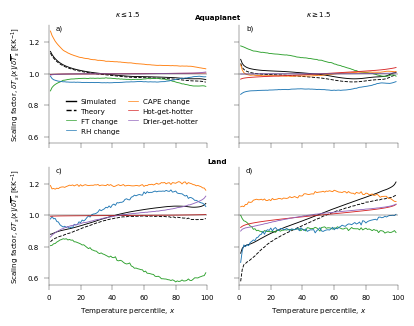

In [53]:
colors_cont = {'temp_ft_change': default_colors[2],
               'temp_anom': default_colors[3], 'r_anom': default_colors[4],
               'r_change': default_colors[0],
               'cape_change': default_colors[1], 'z_approx': default_colors[5]}

save_sf_breakdown_fig = False
fig, ax = plt.subplots(2,2, sharey=True, sharex=True)
fig_resize(fig, width['two_thirds'])
for j, key2 in enumerate(plot_info):
    for i in range(1, 3):
        ax[j, i-1].plot(quant_plot, np.average(plot_info[key2]['sf'][i], axis=0, weights=lat_weights),
                        color='k', lw=1, label='Simulated')
        ax[j, i-1].plot(quant_plot, np.average(plot_info[key2]['sf_theory']['linear'][i], axis=0, weights=lat_weights),
                        color='k', lw=1, linestyle='--', label='Theory')
        for key in plot_info[key2]['sf_theory_cont']:
            if 'no_lapse' in key or 'dist' in key or 'p_x' in key:
                continue
            ax[j, i-1].plot(quant_plot, (0 if 'ft' in key else 1)+np.average(plot_info[key2]['sf_theory_cont'][key][i], axis=0, weights=lat_weights),
                    color=colors_cont[key], label=labels_cont[key])
    ax[j, 0].set_ylabel('Scaling factor, $\delta T_s(x)/\delta \overline{T}_s$ [KK$^{-1}$]')

ax[0, 0].set_title(sf_labels[1])
ax[0, 1].set_title(sf_labels[2])
add_legend(ax[0, 0], ncol=2, loc='lower right')
label_subplots(fig, ax.flatten(), pos_y=0, box_alpha=0)
ax[0, 0].set_xlim(0,100)
ax[0, 0].set_ylim(0.56, 1.31)
ax[1, 0].set_xlabel('Temperature percentile, $x$')
ax[1, 1].set_xlabel('Temperature percentile, $x$')
fig.text(0.5, 0.895, "Aquaplanet", ha='center', fontweight='bold')
fig.text(0.5, 0.47, "Land", ha='center', fontweight='bold')
update_fontsize(fig)
update_linewidth(fig)
for ax_use in ax.flatten():
    ax_use.axhline(1, color='k', lw=ax_linewidth)
plt.show()
if save_sf_breakdown_fig or save_fig:
    isca_tools.savefig(fig, 'sf_breakdown', dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches,
                       save_if_exists=False)

### Figure - Numerical Scaling Factor Breakdown
Here we plot the contribution from each mechanism to the scaling factor, comparing the numerical contribution to the linear taylor series.

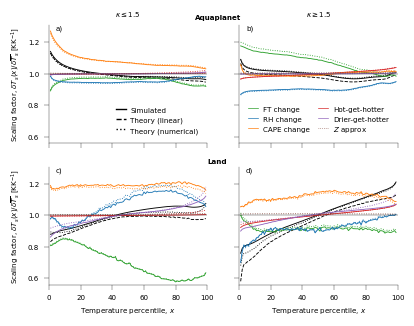

In [63]:
save_sf_breakdown_numerical_fig = True
fig, ax = plt.subplots(2,2, sharey=True, sharex=True)
fig_resize(fig, width['two_thirds'])
for j, key2 in enumerate(plot_info):
    for i in range(1, 3):
        ax[j, i-1].plot(quant_plot, np.average(plot_info[key2]['sf'][i], axis=0, weights=lat_weights),
                        color='k', lw=1, label='Simulated' if i==1 else None)
        ax[j, i-1].plot(quant_plot, np.average(plot_info[key2]['sf_theory']['linear'][i], axis=0, weights=lat_weights),
                        color='k', lw=1, linestyle='--', label='Theory (linear)' if i==1 else None)
        ax[j, i-1].plot(quant_plot, np.average(plot_info[key2]['sf_theory']['numerical'][i], axis=0, weights=lat_weights),
                        color='k', lw=1, linestyle=':', label='Theory (numerical)' if i==1 else None)
        for key in plot_info[key2]['sf_theory_cont']:
            if 'no_lapse' in key or 'dist' in key or 'p_x' in key:
                continue
            ax[j, i-1].plot(quant_plot, (0 if 'ft' in key else 1)+np.average(plot_info[key2]['sf_theory_cont'][key][i], axis=0, weights=lat_weights),
                    color=colors_cont[key], label=labels_cont[key] if i==2 else None)
            if 'cape' not in key:
                ax[j, i-1].plot(quant_plot, (0 if 'ft' in key else 1)+np.average(plot_info[key2]['sf_theory_numerical_cont'][key][i],
                                                                             axis=0, weights=lat_weights),
                            color=colors_cont[key], linestyle=':')
        ax[j, i-1].plot(quant_plot, (0 if 'ft' in key else 1)+
                        np.average(plot_info[key2]['sf_theory_numerical_cont']['epsilon_anom'][i] +
                                   plot_info[key2]['sf_theory_numerical_cont']['epsilon_change'][i],
                                   axis=0, weights=lat_weights), color=colors_cont['cape_change'], linestyle=':')
        ax[j, i-1].plot(quant_plot, (0 if 'ft' in key else 1)+
                        np.average(plot_info[key2]['sf_theory_numerical_cont']['z_approx_anom'][i] +
                                   plot_info[key2]['sf_theory_numerical_cont']['z_approx_change'][i],
                                   axis=0, weights=lat_weights), color=colors_cont['z_approx'], linestyle=':',
                        label='$Z$ approx' if i==2 else None)
    ax[j, 0].set_ylabel('Scaling factor, $\delta T_s(x)/\delta \overline{T}_s$ [KK$^{-1}$]')

ax[0, 0].set_title(sf_labels[1])
ax[0, 1].set_title(sf_labels[2])
add_legend(ax[0, 0], ncol=1, loc='lower right')
add_legend(ax[0, 1], ncol=2, loc='lower right')
label_subplots(fig, ax.flatten(), pos_y=0, box_alpha=0)
ax[0, 0].set_xlim(0,100)
ax[0, 0].set_ylim(0.56, 1.31)
ax[1, 0].set_xlabel('Temperature percentile, $x$')
ax[1, 1].set_xlabel('Temperature percentile, $x$')
fig.text(0.5, 0.895, "Aquaplanet", ha='center', fontweight='bold')
fig.text(0.5, 0.47, "Land", ha='center', fontweight='bold')
update_fontsize(fig)
update_linewidth(fig)
for ax_use in ax.flatten():
    ax_use.axhline(1, color='k', lw=ax_linewidth)
plt.show()
if save_sf_breakdown_numerical_fig or save_fig:
    isca_tools.savefig(fig, 'sf_breakdown_numerical', dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight',
                       pad_inches=save_pad_inches, save_if_exists=False)

### Figure - Approx
Here we show the approximations associated with the theory, highlighting the 3 large approximations in the land simulations in solid lines. The sum is show by a solid black line.

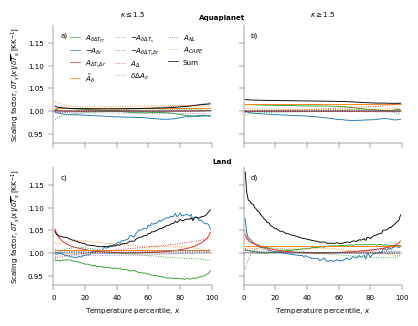

In [41]:
colors_approx = {'temp_ft_anom_change': default_colors[2], 'r_change': default_colors[0], 'anom_temp_s_r': default_colors[3],
                 'ref_change': default_colors[1],
                 'temp_s_anom_change': default_colors[2], 'temp_s_anom_r_change': default_colors[0], 'anom': default_colors[3],
                 'z_anom_change': default_colors[4], 'nl': default_colors[5], 'cape': default_colors[1]}
linestyles_approx = {'temp_ft_anom_change': None, 'r_change': None, 'anom_temp_s_r': None, 'ref_change': None,
                     'temp_s_anom_change': ':', 'temp_s_anom_r_change': ':', 'z_anom_change': ':', 'anom': ':', 'nl': ':', 'cape': ':'}
labels_approx = {'temp_ft_anom_change': '$A_{\delta \Delta T_{FT}}$', 'r_change': '$-A_{\delta r}$', 'anom_temp_s_r': '$A_{\Delta T_s \Delta r}$',
                 'ref_change': '$\\tilde{A}_{\delta}$', 'temp_s_anom_change': '$-A_{\delta \Delta T_s}$',
                 'temp_s_anom_r_change': '$-A_{\delta \Delta T_s \delta r}$', 'z_anom_change': '$\delta \Delta A_z$',
                 'anom': '$A_{\Delta}$', 'nl': '$A_{NL}$', 'cape': '$A_{CAPE}$'}
label_use = ['$A_{\delta \Delta T_{FT}}-A_{\delta r}+A_{\Delta T_s \Delta r}+\\tilde{A}_{\delta}$',
             '$A_{\delta \Delta T_s}+A_{\delta \Delta T_s \delta r}+A_{\Delta}+\\tilde{A}_{\delta}+\delta \Delta A_z+A_{NL}$']

save_sf_approx_fig = True
fig, ax = plt.subplots(2,2, sharey=True, sharex=True)
fig_resize(fig, width['two_thirds'])
for j, key2 in enumerate(plot_info):
    for i in range(1, 3):
        for key in colors_approx:
            ax[j, i-1].plot(quant_plot, 1+np.average(plot_info[key2]['sf_theory_approx'][key][i], axis=0, weights=lat_weights),
                    color=colors_approx[key], label=labels_approx[key] if (i==1 and j==0) else None, linestyle=linestyles_approx[key])
        # if key2 == 'land':
        ax[j, i-1].plot(quant_plot, 1+np.average(sum([plot_info[key2]['sf_theory_approx'][key][i]
                                                      for key in linestyles_approx]),
                                                 axis=0, weights=lat_weights), color='k', label='Sum' if (i==1) and (key2=='aquaplanet') else None)
            # ax[j, i-1].plot(quant_plot, 1+np.average(sum([plot_info[key2]['sf_theory_approx'][key][i]
            #                                               for key in linestyles_approx if linestyles_approx[key]!=None]),
            #                                          axis=0, weights=lat_weights), color='k', linestyle=':', label=label_use[1] if i==1 else None)
    ax[j, 0].set_ylabel('Scaling factor, $\delta T_s(x)/\delta \overline{T}_s$ [KK$^{-1}$]')

ax[0, 0].set_title(sf_labels[1])
ax[0, 1].set_title(sf_labels[2])
add_legend(ax[0, 0], ncol=3, loc='upper right')
# add_legend(ax[1, 0], loc='upper right')
label_subplots(fig, ax.flatten())
ax[0, 0].set_xlim(0,100)
# ax[0, 0].set_ylim(0.56, 1.31)
ax[1, 0].set_xlabel('Temperature percentile, $x$')
ax[1, 1].set_xlabel('Temperature percentile, $x$')
fig.text(0.5, 0.895, "Aquaplanet", ha='center', fontweight='bold')
fig.text(0.5, 0.47, "Land", ha='center', fontweight='bold')
update_fontsize(fig)
update_linewidth(fig)
for ax_use in ax.flatten():
    ax_use.axhline(1, color='k', lw=ax_linewidth)
plt.show()
if save_sf_approx_fig or save_fig:
    isca_tools.savefig(fig, 'sf_approx', dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches,
                       save_if_exists=False)

# fig, ax = plt.subplots(1,2, figsize=(2*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
# for j, key2 in enumerate(plot_info):
#     for key in colors_approx:
#         ax[j].plot(quant_plot, 1+np.average(plot_info[key2]['sf_theory_approx'][key][2], axis=0, weights=lat_weights),
#                 color=colors_approx[key], label=labels_approx[key], linestyle=linestyles_approx[key])
#     ax[j].plot(quant_plot, 1+np.average(sum([plot_info[key2]['sf_theory_approx'][key][2] for key in linestyles_approx if linestyles_approx[key]==None]),
#                                         axis=0, weights=lat_weights),
#                 color='k')
#     ax[j].plot(quant_plot, 1+np.average(sum([plot_info[key2]['sf_theory_approx'][key][2] for key in linestyles_approx if linestyles_approx[key]!=None]),
#                                         axis=0, weights=lat_weights),
#                 color='k', linestyle='--')
#     ax[j].axhline(1, color='k', lw=ax_linewidth)
#     ax[j].set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$, contribution')
# # ax[0].set_ylim(0.7, 1.3)
# ax[0].legend(ncol=3)

### Figure - Lapse Rate
a) is just to illustrate that the moist adiabat lapse rate decreases with warming, while the dry adiabat remains constant. Useful to explain the mechanisms.

b) is to illustrate how CAPE affects bulk lapse rate for given RH.

In [42]:
def get_bulk_lapse(temp_surf, cape=0, rh=1, pressure_surf=p_surface, pressure_ft=pressure_ft_actual):
    # cape in units of J/kg
    # Compute the bulk lapse rate for a given epsilon, surface temperature and surface RH
    temp_ft_parcel = np.asarray([get_temp_adiabat(temp_surf[i], rh*sphum_sat(temp_surf[i], pressure_surf), pressure_surf, pressure_ft
                                                  )[0] for i in range(len(temp_surf))])
    temp_ft = temp_ft_parcel - cape/R_mod
    return g*np.log(temp_surf/temp_ft)/2/R_mod, temp_ft

def get_bulk_lapse_from_ft(temp_ft, cape=0, rh=1, pressure_surf=p_surface, pressure_ft=pressure_ft_actual):
    # for a given ft temperature, returns bulk lapse rate and surface temperature
    temp_ft_parcel = temp_ft + cape/R_mod
    temp_surf = np.asarray([get_temp_adiabat_surf(rh, temp_ft_parcel[i], None, pressure_surf, pressure_ft,
                                                  rh_form=True)[0] for i in range(len(temp_ft))])
    return g*np.log(temp_surf/temp_ft)/2/R_mod, temp_surf

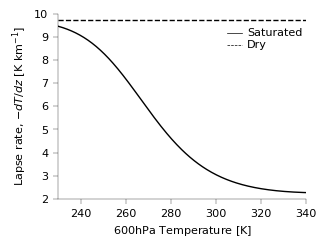

In [43]:
save_lapse_fig = False
lapse_plot_pressure = 600 * 100
lapse_plot_temp = np.linspace(230, 340, 300)
lapse_plot_z_coords = True

fig, ax = plt.subplots(1,1, sharex=True, sharey=True)
fig_resize(fig, width['one_col'])
if lapse_plot_z_coords:
    ax.plot(lapse_plot_temp, lapse_moist(lapse_plot_temp, lapse_plot_pressure) * 1000, color='k', label='Saturated')
    ax.axhline(lapse_dry * 1000, color='k', label='Dry', linestyle='--')
    ax.set_ylabel('Lapse rate, $-dT/dz$ [K km$^{-1}$]')
else:
    ax.plot(lapse_plot_temp, lapse_moist(lapse_plot_temp, lapse_plot_pressure, True) * 100, color='k', label='Saturated')
    ax.plot(lapse_plot_temp, lapse_dry * R * lapse_plot_temp / (lapse_plot_pressure * g) * 100, color='k', label='Dry', linestyle='--')
    ax.set_ylabel('Lapse rate, $dT/dp$ [K hPa$^{-1}$]')
legend = add_legend(ax, handlelength=1.6)
legend.set_bbox_to_anchor((1.02, 1-0.03))
ax.set_xlabel('${:.0f}$hPa Temperature [K]'.format(lapse_plot_pressure/100))

ax.set_xlim(lapse_plot_temp[0], lapse_plot_temp[-1])
ax.set_ylim(2, 10)
update_fontsize(fig)
update_linewidth(fig)
plt.show()


# Cold get hotter - lapse rate decreases more for hot day than cold day
# temp_change_use = 15
# temp_day_diff_use = 10
# marker_size = 30
# # marker_use = ['.', '+']
# # for i, temp_cold_use in enumerate([237, 270]):
# marker_use = ['+']
# if lapse_plot_z_coords:
#     for i, temp_cold_use in enumerate([280]):
#         ax.scatter(temp_cold_use, lapse_moist(temp_cold_use, lapse_plot_pressure, not lapse_plot_z_coords)*1000, color='b', marker=marker_use[i],
#                    s=marker_size, zorder=3)   # zorder brings markers to front
#         ax.scatter(temp_cold_use+temp_change_use, lapse_moist(temp_cold_use+temp_change_use, lapse_plot_pressure, not lapse_plot_z_coords)*1000,
#                    color='b', marker=marker_use[i], s=marker_size, zorder=3)
#         ax.scatter(temp_cold_use+temp_day_diff_use, lapse_moist(temp_cold_use+temp_day_diff_use, lapse_plot_pressure, not lapse_plot_z_coords)*1000, color='r',
#                    marker=marker_use[i], s=marker_size, zorder=3)
#         ax.scatter(temp_cold_use+temp_day_diff_use+temp_change_use,
#                    lapse_moist(temp_cold_use+temp_day_diff_use+temp_change_use, lapse_plot_pressure, not lapse_plot_z_coords)*1000,
#                    color='r', marker=marker_use[i], s=marker_size, zorder=3)

if save_fig or save_lapse_fig:
    isca_tools.savefig(fig, 'lapse_rate', dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches,
                       save_if_exists=False)

### Figure - $\delta T_{FT}[x]$ Breakdown
The $FT$ temperature change influences the surface temperature distribution directly i.e. if warm troposphere and don't change lapse rate then surface will warm by some amount. There is also a lapse rate contribution due to the effect above, that the lapse rate decreases with warming, giving a negative contribution to surface temperature.

This decomposition is shown below.

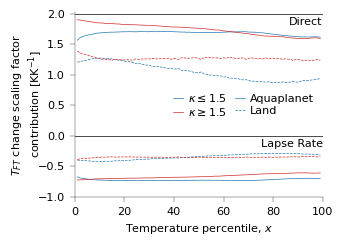

In [44]:
save_ft_breakdown_fig = False

fig, ax = plt.subplots(1,1, sharex=True, sharey=False)
fig_resize(fig, width['one_col'])
for j, key2 in enumerate(plot_info):
    for i in range(1, 3):
        ax.plot(quant_plot, np.average(plot_info[key2]['sf_theory_cont']['temp_ft_change_no_lapse'][i], axis=0, weights=lat_weights),
                   color=colors_sf_tau[i], linestyle=linestyles_surf[key2], label=key2.capitalize() if i==1 else None)
        ax.plot(quant_plot, np.average(plot_info[key2]['sf_theory_cont']['temp_ft_change'][i] -
                                          plot_info[key2]['sf_theory_cont']['temp_ft_change_no_lapse'][i], axis=0, weights=lat_weights),
                   color=colors_sf_tau[i], linestyle=linestyles_surf[key2], label=sf_labels[i] if j==0 else None)

# Re-order legend so have 4 entries
ax.legend()
# Get existing legend handles and labels
handles, labels = ax.get_legend_handles_labels()
# Define new order (e.g., swap Sine and Cosine)
order = [1, 2, 0, 3]  # New index order
# Update legend with new order **after plotting**
add_legend(ax, [handles[i] for i in order], [labels[i] for i in order], ncol=2, loc='center right')
ax.set_ylim(-1, 2.03)
ax.text(100, 2-0.05, "Direct", color='k', va='top', ha='right')
ax.text(100, -0.05, "Lapse Rate", color='k', va='top', ha='right')
ax.axhline(0, color='k')
ax.axhline(2, color='k')
ax.set_xlim(0,100)
ax.set_xlabel('Temperature percentile, $x$')
ax.set_ylabel('$T_{FT}$ change scaling factor\ncontribution [KK$^{-1}$]')
ax.yaxis.set_label_coords(-0.12, 0.5)
update_fontsize(fig)
update_fontsize(fig)
plt.show()

if save_ft_breakdown_fig or save_fig:
    isca_tools.savefig(fig, 'ft_breakdown', dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches,
                       save_if_exists=False)

### Figure - Percentile Scaling Factor Contribution
The change mechanisms are a change in a variable conditioned on near-surface percentile, $\delta \chi[x]$. This can be broken down into a contribution from the change in the distribution, $\delta \chi(x)$, as well as a change in percentile corresponding to $x$, and no change in distribution: $\chi(p_x+\delta p_x) - \chi(p_x)$.

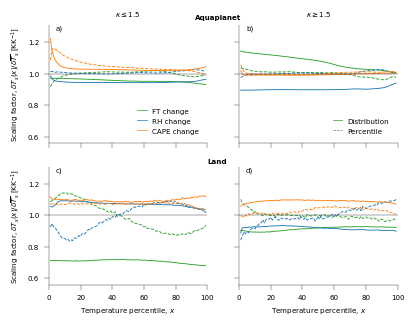

In [45]:
save_sf_percentile_fig = False
show_sum = False        # option to show sum of dashed / solid lines in black but think it complicates plot
fig, ax = plt.subplots(2,2, sharey=True, sharex=True)
fig_resize(fig, width['two_thirds'])
for j, key2 in enumerate(plot_info):
    for i in range(1, 3):
        # ax[j, i-1].plot(quant_plot, np.average(plot_info[key2]['sf_theory']['linear'][i], axis=0, weights=lat_weights),
        #                 color='k', lw=1, linestyle='--', label='Theory')
        for key in plot_info[key2]['sf_theory_cont']:
            if 'dist' in key or 'p_x' in key:
                if key == 'temp_ft_change_dist' and j==0 and i==2:
                    label_use = 'Distribution'
                elif key == 'temp_ft_change_p_x' and j==0 and i==2:
                    label_use = 'Percentile'
                elif 'dist' in key and j==0 and i==1:
                    label_use = labels_cont[key.replace('_dist', '').replace('_p_x', '')]
                else:
                    label_use = None
                ax[j, i-1].plot(quant_plot, (0 if 'ft_change_dist' in key else 1)+np.average(plot_info[key2]['sf_theory_cont'][key][i],
                                                                                      axis=0, weights=lat_weights),
                                linestyle='--' if 'p_x' in key else None, label=label_use,
                                color=colors_cont[key.replace('_dist', '').replace('_p_x', '')])
        if show_sum:
            for key3 in ['dist', 'p_x']:
                ax[j, i-1].plot(quant_plot, (0 if 'dist' in key3 else 1) +
                                np.average(sum([plot_info[key2]['sf_theory_cont'][key+'_change_'+key3][i] for key in ['temp_ft', 'r', 'cape']]),
                                           axis=0, weights=lat_weights), linestyle='--' if key3=='p_x' else None, color='k')
    ax[j, 0].set_ylabel('Scaling factor, $\delta T_s(x)/\delta \overline{T}_s$ [KK$^{-1}$]')

ax[0, 0].set_title(sf_labels[1])
ax[0, 1].set_title(sf_labels[2])
add_legend(ax[0, 0], loc='lower right')
add_legend(ax[0, 1], loc='lower right')
label_subplots(fig, ax.flatten(), pos_y=0, box_alpha=0)
ax[0, 0].set_xlim(0,100)
ax[0, 0].set_ylim(0.56, 1.31)
ax[1, 0].set_xlabel('Temperature percentile, $x$')
ax[1, 1].set_xlabel('Temperature percentile, $x$')
fig.text(0.5, 0.895, "Aquaplanet", ha='center', fontweight='bold')
fig.text(0.5, 0.47, "Land", ha='center', fontweight='bold')
update_fontsize(fig)
update_linewidth(fig)
for ax_use in ax.flatten():
    ax_use.axhline(1, color='k', lw=ax_linewidth)
plt.show()
if save_sf_percentile_fig or save_fig:
    isca_tools.savefig(fig, 'sf_percentile', dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches,
                       save_if_exists=False)

### Figure - Percentile change with warming
Below I plot how the percentile corresponding to $x$ changes between each simulation.

Interesting that in the hottest simulations, the coldest days at the surface correspond to the hottest at the free troposphere.

In [46]:
if not load_data:
    p_x = {key: np.zeros((n_kappa, n_lat, n_quant)) for key in ['temp_ft', 'r', 'cape']}
    for i in range(n_kappa):
        for j in range(n_lat):
            p_x['temp_ft'][i, j] = get_p_x(temp_quant3[i, ind_ft, j], temp_ft_quant[i, j], quant_px)[0]
            p_x['r'][i, j] = get_p_x(r_quant3[i, j], r_quant[i, j], quant_px)[0]

            # For cape, in aquaplanet quick method can have cape_quant.min() larger than cape_quant3.min() - deal with that here
            var_use = cape_quant[i, j] * 1
            if cape_quant3[i, j].min() < cape_quant[i, j].min():
                warnings.warn(f'i={i}, j={j}: cape in cape_quant3 lower than in cape_quant; changing cape_quant[0] to cape_quant3[0]')
                var_use[0] = cape_quant3[i, j].min()
            if cape_quant3[i, j].max() > cape_quant[i, j].max():
                warnings.warn(f'i={i}, j={j}: cape in cape_quant3 larger than in cape_quant; changing cape_quant[-1] to cape_quant3[-1]')
                var_use[-1] = cape_quant3[i, j].max()
            p_x['cape'][i, j] = get_p_x(cape_quant3[i, j], var_use, quant_px)[0]

    for key in ['aquaplanet', 'land']:
        try:
            plot_info[key]['p_x']       # just to key exists
        except KeyError:
            # If variable doesn't exist, create it with all values set to 0
            plot_info[key]['p_x'] = {key2: np.zeros((n_kappa, n_lat, n_quant)) for key2 in ['temp_ft', 'r', 'cape']}

    # Update plot dict for current loaded simulation
    for key in p_x:
        plot_info['land' if is_land_data else 'aquaplanet']['p_x'][key][:] = p_x[key]

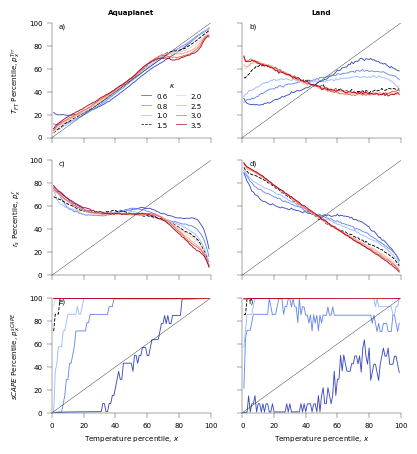

In [47]:
save_percentile_fig = False
fig, ax = plt.subplots(3,2, sharex=True, sharey=True)
fig_resize(fig, width['two_thirds'])
for j, key2 in enumerate(plot_info):
    ax[0, j].set_title(key2.capitalize(), fontweight='bold')
    for k, key in enumerate(plot_info[key2]['p_x']):
        for i in range(n_kappa):
            ax[k, j].plot(quant_plot, np.average(plot_info[key2]['p_x'][key][i],axis=0, weights=lat_weights), color=colors_kappa[i],
                          linestyle='--' if i==3 else None, label='{:.1f}'.format(tau_lw[i]))
ax[0,0].set_ylim(0, 100)
ax[0,0].set_xlim(0, 100)
add_legend(ax[0, 0], ncol=2, title='$\kappa$', loc='lower right')
ax[0, 0].set_ylabel('$T_{FT}$ Percentile, $p_x^{T_{FT}}$')
ax[1, 0].set_ylabel('$r_s$ Percentile, $p_x^{r}$')
ax[2, 0].set_ylabel('$sCAPE$ Percentile, $p_x^{sCAPE}$')
ax[2, 0].set_xlabel('Temperature percentile, $x$')
ax[2, 1].set_xlabel('Temperature percentile, $x$')
label_subplots(fig, ax.flatten(), box_alpha=0, pos_y=0)
update_linewidth(fig)
update_fontsize(fig)
for ax_use in ax.flatten():
    ax_use.plot([0, 100], [0, 100], color='k', lw=ax_linewidth)
plt.show()
if save_percentile_fig or save_fig:
    isca_tools.savefig(fig, 'percentile', dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches,
                       save_if_exists=False)

## Schematics
Make schematics to illustrate physical mechanisms, with an approximate moist lapse rate following exponential decay with temperature.

In figures, dashed lines indicate current climate. Dotted lines are if warm at FT with no lapse rate change. Black lines indicate day with no CAPE in current climate and no RH or CAPE change with warming. Red lines indicate change according to mechanism under consideration, which results in amplified warming. Dotted blue lines indicate moist adiabatic profile given surface conditions.

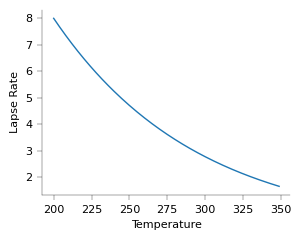

In [48]:
# Define approximate moist lapse rate to follow exponential decay function, so near dry adiabat at low temperatures and moist adiabat at high temp
def moist_lapse_exp_decay(x, dry_lapse=10, temp_dry=200, temp0=350, decay_sigma=10):
    # Define approximate moist lapse rate to follow exponential decay function, so equal 0.8*dry lapse rate at temp_dry, and nearly zero at temp0.
    # Decay_sigma controlls the rate of the decay with temperature, smaller means more rapid decay
    # Given conditions
    x_start, x_end = temp_dry, temp0
    y_start, y_end = 0.8*dry_lapse, 1e-6  # Assume nearly zero at x=300

    # Solve for decay rate k
    k = np.log(y_start / y_end) / (x_end - x_start)
    return y_start * np.exp(-k * (x - x_start)/decay_sigma)
fig, ax = plt.subplots(1,1)
fig_resize(fig, width['one_col'])
ax.plot(np.arange(200, 350), moist_lapse_exp_decay(np.arange(200, 350), 10))
ax.set_xlabel('Temperature')
ax.set_ylabel('Lapse Rate')
update_fontsize(fig)
update_linewidth(fig)
plt.show()

In [49]:
schem_info = {'lapse_dry': 10,
              'lapse_moist': moist_lapse_exp_decay,
              'height': np.linspace(0, 10, 1000), # moist lapse rate decreases from lapse dry to 0, between 200K and 300K
              'temp_ft0': 240,
              'lcl0': 3,
              'lcl_large': 7,
              'temp_ft_change': 50,
              'temp_anom': 85,
              'color_mech': default_colors[3],
              'color_cape': default_colors[3],
              'linestyle_cape': '-.',
              'dash_cape': [10, 4, 1, 5],       # Dash, Gap, Dot, Gap
              'cape_lapse_change': 4,
              'cape_lapse_anom': -2
              }
def get_schem_profile(temp_ft=schem_info['temp_ft0'], lcl=schem_info['lcl0'], height=schem_info['height'], lapse_moist_mod=0):
    # Lapse_moist_mod is epsilon or CAPE, larger means more CAPE i.e. lapse rate further from moist, closer to dry adiabat
    temp_profile = np.zeros_like(height)
    temp_profile[height>=lcl] = temp_ft + (schem_info['lapse_moist'](temp_ft)+lapse_moist_mod) * (height[-1]-height[height>=lcl])
    lcl_ind = np.where(height>=lcl)[0][0]
    temp_profile[height<lcl] = temp_profile[lcl_ind] + schem_info['lapse_dry'] * (height[lcl_ind]-height[height<lcl])
    return temp_profile

def get_schem_profile_from_surf(temp_surf, lcl=schem_info['lcl0'], height=schem_info['height'], lapse_moist_mod=0):
    def func_to_minimize(x):
        # Find surface temperature of profile given x as temp_ft
        # Return difference between this and desired temp_surf
        return np.abs(get_schem_profile(x, lcl, height, lapse_moist_mod)[0]-temp_surf)
    # First find ft temperature that gives the surface temperature
    temp_ft_use = scipy.optimize.minimize_scalar(func_to_minimize, bounds=(200, 380), method="bounded").x
    return get_schem_profile(temp_ft_use, lcl, height, lapse_moist_mod)

schem_info['temp_s0'] = get_schem_profile()[0]      # surface temperature in reference climate

In [50]:
def move_axis_to_center(ax):
    # Get positions of original left and right bottom subplots
    pos_left = ax[2, 0].get_position()
    pos_right = ax[1, 1].get_position()  # any other plot in same column to get width

    # Compute center of the row
    row_center = (pos_left.x0 + pos_right.x0 + pos_right.width) / 2
    new_x0 = row_center - pos_left.width / 2

    # Move the bottom-left subplot to row center
    ax[2, 0].set_position([new_x0, pos_left.y0, pos_left.width, pos_left.height])

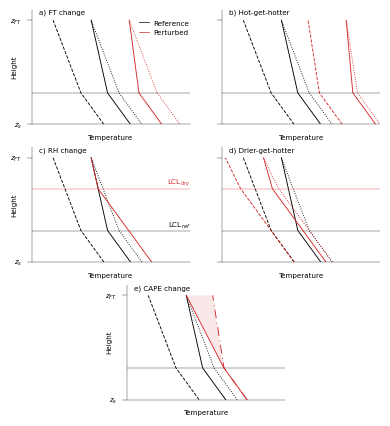

In [51]:
save_schematic_fig = False
fig, ax = plt.subplots(3,2, sharex=True, sharey=True)
fig_resize(fig, width['two_thirds'])
ax[2, 1].remove()
move_axis_to_center(ax)

# Plot change along moist adiabat in all figures
for i, ax_use in enumerate(ax.flatten()):
    ax_use.plot(get_schem_profile(), schem_info['height'], color='k', linestyle='--')
    ax_use.plot(get_schem_profile()+schem_info['temp_ft_change'], schem_info['height'], color='k', linestyle=':')
    # Remove axis info
    ax_use.plot(get_schem_profile(schem_info['temp_ft0']+schem_info['temp_ft_change']), schem_info['height'], color='k', label='Reference')
    ax_use.set_xticks([])
    ax_use.set_yticks([0, 10], ['$z_s$', '$z_{FT}$'])
    ax_use.set_xlabel('Temperature')
    # ax_use.tick_params(axis='both', which='both', length=0)
    # ax_use.set_xticklabels([])
    # ax_use.set_yticklabels([])

# FT Change
ax[0, 0].plot(get_schem_profile(schem_info['temp_ft0']+schem_info['temp_ft_change']*2), schem_info['height'], color=schem_info['color_mech'],
              label='Perturbed')
ax[0, 0].plot(get_schem_profile()+schem_info['temp_ft_change']*2, schem_info['height'], color=schem_info['color_mech'], linestyle=':')
add_legend(ax[0, 0], loc='upper right', bbox_to_anchor=(1.05, 1))

# Temp climatological
ax[0, 1].plot(get_schem_profile(schem_info['temp_ft0']+schem_info['temp_anom']), schem_info['height'], color=schem_info['color_mech'], linestyle='--')
ax[0, 1].plot(get_schem_profile(schem_info['temp_ft0']+schem_info['temp_anom']+schem_info['temp_ft_change']),
              schem_info['height'], color=schem_info['color_mech'])
ax[0, 1].plot(get_schem_profile(schem_info['temp_ft0']+schem_info['temp_anom'])+schem_info['temp_ft_change'], schem_info['height'],
              color=schem_info['color_mech'], linestyle=':')

# RH Change
ax[1, 0].plot(get_schem_profile(schem_info['temp_ft0']+schem_info['temp_ft_change'], schem_info['lcl_large']),
              schem_info['height'], color=default_colors[3])

# RH climatological
schem_profile0 = get_schem_profile_from_surf(schem_info['temp_s0'], lcl=schem_info['lcl_large'])
ax[1, 1].plot(schem_profile0, schem_info['height'], color=schem_info['color_mech'], linestyle='--')
ax[1, 1].plot(get_schem_profile(schem_profile0[-1]+schem_info['temp_ft_change'], schem_info['lcl_large']),
              schem_info['height'], color=schem_info['color_mech'])
ax[1, 1].plot(schem_profile0+schem_info['temp_ft_change'], schem_info['height'],
              color=schem_info['color_mech'], linestyle=':')

# CAPE change
schem_profile_warm = get_schem_profile(schem_info['temp_ft0']+schem_info['temp_ft_change'], lapse_moist_mod=schem_info['cape_lapse_change'])
ax[2, 0].plot(schem_profile_warm, schem_info['height'],
              color=schem_info['color_mech'])
ax[2, 0].plot(get_schem_profile_from_surf(schem_profile_warm[0]),
              schem_info['height'],
              color=schem_info['color_cape'], linestyle=schem_info['linestyle_cape'], dashes=schem_info['dash_cape'])
# Shade to highlight the generation of CAPE
interp_shade_func = scipy.interpolate.interp1d(get_schem_profile_from_surf(schem_profile_warm[0]), schem_info['height'],
                                               fill_value=schem_info['height'][-1], bounds_error=False, kind='nearest')
# interp_shade_func = scipy.interpolate.interp1d(get_schem_profile_from_surf(schem_profile_warm[0]),
#                                                schem_info['height'], fill_value='extrapolate', bounds_error=False)
ax[2, 0].fill_between(schem_profile_warm, schem_info['height'], interp_shade_func(schem_profile_warm), color=schem_info['color_cape'],
                      alpha=0.1, edgecolor='none')

ax[0, 0].get_xlim()
ax[0, 0].set_xlim(212, 420)
ax[0, 0].set_ylim(0, schem_info['height'][-1]+1)
for i in range(3):
    ax[i, 0].set_ylabel('Height', labelpad=-5)

# Put titles in letter labels to avoid looking like x axis labels
letter_order = ['a', 'c', 'e', 'b', 'd']
label_subplots(fig, ax.transpose().flatten()[:-1], [f"{letter_order[i]}) " + labels_cont[key] for i, key in enumerate(labels_cont)],
               box_alpha=0, pos_y=0)

ax[1, 0].text(ax[1,0].get_xlim()[1], schem_info['lcl0'], "LCL$_{ref}$", color='k', va='bottom', ha='right')
ax[1, 0].text(ax[1,0].get_xlim()[1], schem_info['lcl_large'], "LCL$_{dry}$", color=schem_info['color_mech'], va='bottom', ha='right')
# ax.text(100, -0.05, "Lapse Rate", color='k', va='top', ha='right')

update_fontsize(fig)
update_linewidth(fig)

for ax_use in ax.flatten():
    ax_use.axhline(schem_info['lcl0'], color='k', lw=ax_linewidth)
ax[1,0].axhline(schem_info['lcl_large'], color=schem_info['color_mech'], lw=ax_linewidth)
ax[1,1].axhline(schem_info['lcl_large'], color=schem_info['color_mech'], lw=ax_linewidth)
#plt.subplots_adjust(wspace=0.08)            # move axis closer together
plt.show()

if save_schematic_fig or save_fig:
    isca_tools.savefig(fig, 'schematic', dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches,
                       save_if_exists=False)

## Save data
To make generating figures quicker later on, save `plot_info` dictionary required to create figures here.

In [52]:
save_data = False
if save_data:
    if is_land_data:
        save_file = os.path.join(fig_data_dir, 'land_evap.npz' if use_land_evap else 'land.npz')
    else:
        save_file = os.path.join(fig_data_dir, 'aquaplanet.npz')
    if os.path.exists(save_file):
        print('File already exists:\n{}'.format(save_file))
    else:
        np.savez_compressed(save_file, data=np.array(list(plot_info['land' if is_land_data else 'aquaplanet'].items()), dtype=object))
        print("plot_info[{}] saved to\n{}".format("'land'" if is_land_data else "'aquaplanet'", save_file))